

# Data Science Workshop in Ivano-Frankivsk on April 2018

## by Tatyana Gladkyh and Dmytro Zikrach (DSG, SoftServe)

# 1. Load modules

In [1]:
!pip install tqdm

You are using pip version 9.0.2, however version 10.0.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
%matplotlib inline
import base64
import numpy as np
import pandas as pd
from io import BytesIO
from itertools import combinations
from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, r2_score, mean_squared_error


from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster, linkage, dendrogram

import statsmodels.api as sm

from IPython.display import HTML, Image

/usr/local/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# 2. Define functions for output models result

In [3]:
sns.set()

def prepare_data(X, y):
    """
    Convert and split data
    """
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
    for train_index, test_index in split.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
    return X_train, X_test, y_train, y_test

def evaluate_classification(actual, pred, pos_label=1, average='binary', sample_weight = None, fs=4):
    """
    Basic set of evaluation metrics for classification
    """
    return """
    <table style='width:100%'><tr><td style='text-align:left;vertical-align:top'><table style='font-size:14px'> \
    <tr><td><b>Accuracy score:</b></td><td>{1}</td></tr><tr><td><b>F1 score:</b></td><td>{2}</td></tr></table></td> \
    <td>{0}</td></tr></table>
    """.format(confusion_matrix_picture(actual, pred, fs=fs), 
               metrics.accuracy_score(actual, pred, sample_weight=sample_weight), metrics.f1_score(actual, pred, pos_label=pos_label, average=average))

def evaluate_regression(actual, pred, sample_weight = None):
    """
    Basic set of evaluation metrics for regression
    """
    print("RMSE: {}".format(np.sqrt(metrics.mean_squared_error(actual, pred, sample_weight=sample_weight))))
    print("R^2 score: {}".format(metrics.r2_score(actual, pred, sample_weight=sample_weight)))
    df=pd.DataFrame({'actual':actual, 'pred':pred})
    _=df.boxplot('pred','actual', figsize=[7,5])
    _=df.hist('pred','actual', figsize=[7,7])

def evaluate_hclust(actual, link):
    """
    Evaluate hierarchical clustering by plotting several metrics against various number of clusters
    actual -- known instance labels
    link -- result of scipy's linkage function
    """
    amis, chs, ss, vs = [], [], [], []
    for k in range(2,51):
        clusters = fcluster(link, k, 'maxclust')
        amis.append(metrics.adjusted_mutual_info_score(actual, clusters))
        chs.append(metrics.calinski_harabaz_score(X, clusters))
        vs.append(metrics.v_measure_score(actual, clusters))
        ss.append(metrics.silhouette_score(X, clusters))
        
    fig, rows = plt.subplots(2, 2, figsize=(15,10))
    rows[0][0].plot(range(2,51), amis)
    rows[0][0].set_xlim(2,50)
    rows[0][0].set_title("adjusted mutual info score")
    rows[0][1].plot(range(2,51), chs)
    rows[0][1].set_xlim(2,50)
    rows[0][1].set_title("calinski harabas score")
    rows[1][0].plot(range(2,51), vs)
    rows[1][0].set_xlim(2,50)
    rows[1][0].set_title("v-score")
    rows[1][1].plot(range(2,51), ss)
    rows[1][1].set_xlim(2,50)
    rows[1][1].set_title("silhouette score")

def confusion_matrix(actual, pred):
    """
    Confusion matrix in html form
    """
    cm = pd.crosstab(pd.Series(actual, name='Actual'), pd.Series(pred, name='Predicted'), margins=False)
    return cm.to_html().replace('class="dataframe', 'style="font-size:14px"')

def confusion_matrix_picture(actual, pred, fs = 4):
    """
    Confusion matrix in heatmap form
    """
    cm = pd.crosstab(pd.Series(actual, name='Actual'), pd.Series(pred, name='Predicted'), margins=False, 
                     normalize='index')
    fig, ax = plt.subplots(figsize=(fs,fs))
    itm = sns.heatmap(cm, annot=True, linewidths=.5, cmap=plt.cm.viridis_r, ax=ax)
    img = BytesIO()
    fig.savefig(img, format='png')
    plt.close(fig)
    return '<img src="data:image/png;base64,{}"\>'.format(base64.b64encode(img.getvalue()).decode('utf-8'))

def plot_roc_single(actual, score, rev=True, labels={}, fsize=[10,5]):
    """
    Plot single ROC curve
    """
    fig, ax = plt.subplots(figsize=(fsize[0], fsize[1]))
    _plot_roc_curve(ax, actual, score, rev, labels)
    plt.show()

def plot_roc_multiple(actual, score, rev=True, labels={}, titles=[]):
    """
    Plot multiple ROC curves in a 2 cell grid
    """
    num_plots = actual.shape[1]
    nrows = num_plots // 2 if num_plots % 2 == 0 else num_plots // 2 + 1
    fig, axes = plt.subplots(nrows, 2, squeeze=False, figsize=(26, 7 * nrows))
    for idx, row in enumerate(axes):
        title = "ROC for {}".format(titles[idx*2] if idx*2 < len(titles) else 'None')
        _plot_roc_curve(row[0], actual[:, idx*2], score[:, idx*2], rev, labels, title)
        if idx*2+1 < num_plots:
            title = "ROC for {}".format(titles[idx*2+1] if idx*2+1 < len(titles) else 'None')
            _plot_roc_curve(row[1], actual[:, idx*2+1], score[:, idx*2+1], rev, labels, title)
        else:
            fig.delaxes(row[1])
    plt.show()

def _get_data_for(x, y, label):
    """
    Get actual, predicted data for specified label
    """
    idx = np.where(x == label)[0]
    return x[idx], y[idx]

def _plot_roc_curve(ax, actual, score, rev=True, labels={}, title='Receiver operating characteristic'):
    """
    Plot ROC curve with AUC characteristic and baseline for binary case
    """
    fnc=np.vectorize(lambda t: labels.get(t, t))
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    if rev:
        fpr["micro"], tpr["micro"], _ = metrics.roc_curve(fnc(actual).ravel(), score.ravel())
    else:
        fpr["micro"], tpr["micro"], _ = metrics.roc_curve(fnc(actual), score)
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    lw = 2
    k='micro'
    ax.plot(fpr[k], tpr[k], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[k])
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(title)
    ax.legend(loc="lower right")

class MidpointNormalize(colors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)
    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    Code by Joe Kington
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

def background_gradient(s, cmap='bwr', low=0, high=0):
    """
    Color correlations table according to specified colormap
    """
    rng = s.max() - s.min()
    norm = MidpointNormalize(s.min() - (rng * low), s.max() + (rng * high), 0)
    normed = norm(s.values)
    c = [colors.rgb2hex(x) for x in plt.cm.get_cmap(cmap)(normed)]
    return ['background-color: %s' % color for color in c]

def magnify():
    """
    Zoom-in table cell on mouse point
    """
    return [dict(selector="th",
                 props=[("font-size", "10pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "14pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '14pt')])]

def confusion_matrix_simple(actual, pred):
    """
    Confusion matrix in html form
    """
    cm = pd.crosstab(pd.Series(actual, name='Actual'), pd.Series(pred, name='Predicted'), margins=False,
                    normalize='index')
    return cm


def clust_matrix_picture(cm, fs = 4):
    """
    Confusion matrix in heatmap form
    """
    fig, ax = plt.subplots(figsize=(fs,fs))
    itm = sns.heatmap(cm, annot=True, linewidths=.5, cmap=plt.cm.viridis_r, ax=ax)
    img = BytesIO()
    fig.savefig(img, format='png')
    plt.close(fig)
    return '<img src="data:image/png;base64,{}"\>'.format(base64.b64encode(img.getvalue()).decode('utf-8'))


# 3. Load and Preparation Data

In [8]:
# Load red wine
dfr = pd.read_csv("data/winequality-red.csv", sep=';')
dfr['color'] = 'red'
# Load white wine
dfw = pd.read_csv("data/winequality-white.csv", sep=';')
dfw['color'] = 'white'
#Concatenate and shuffle data
df = pd.concat([dfr, dfw])
df = df.sample(frac=1, random_state=3).reset_index(drop=True)

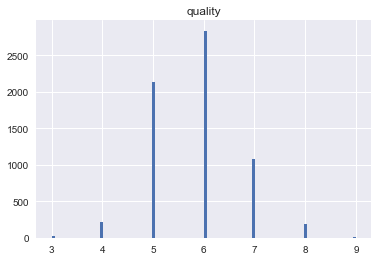

In [9]:
_ = df.hist('quality', bins=100, figsize=(6, 4))

### 3a. Extract class, based on wine quality

In [10]:
df['class'] = df.quality.apply(lambda x: "high" if x > 6 else "low")

# 4. Exploratory analysis

## 4a. Visualizing dependencies

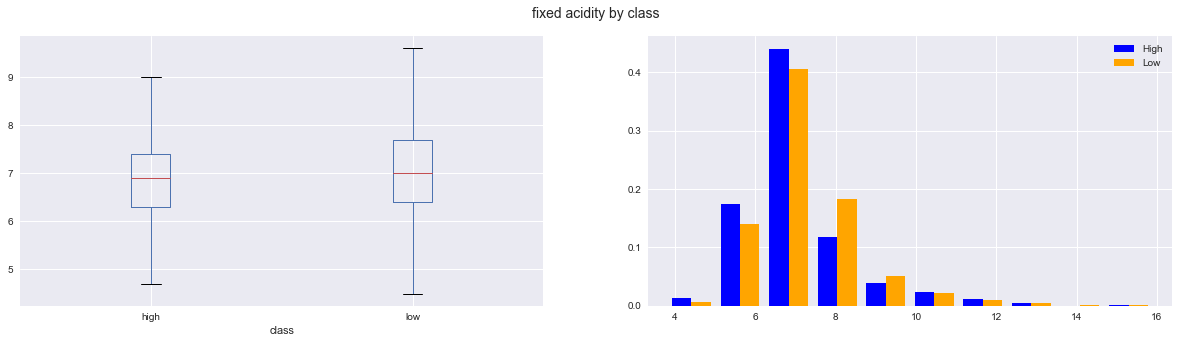

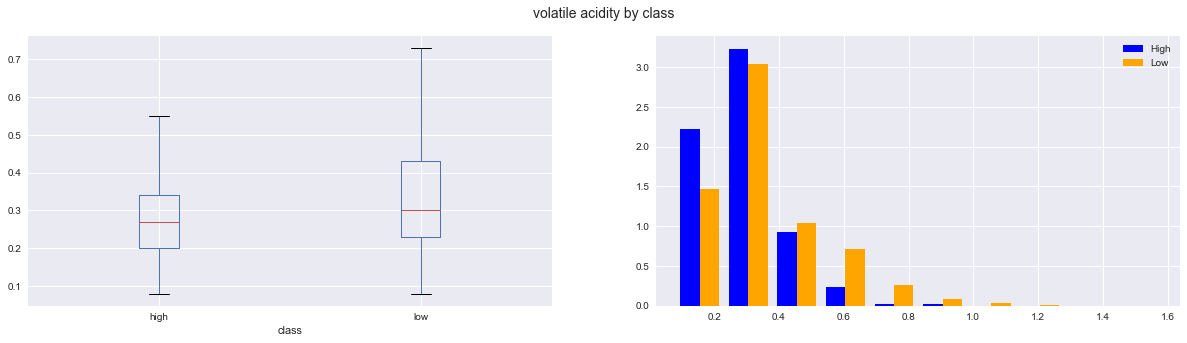

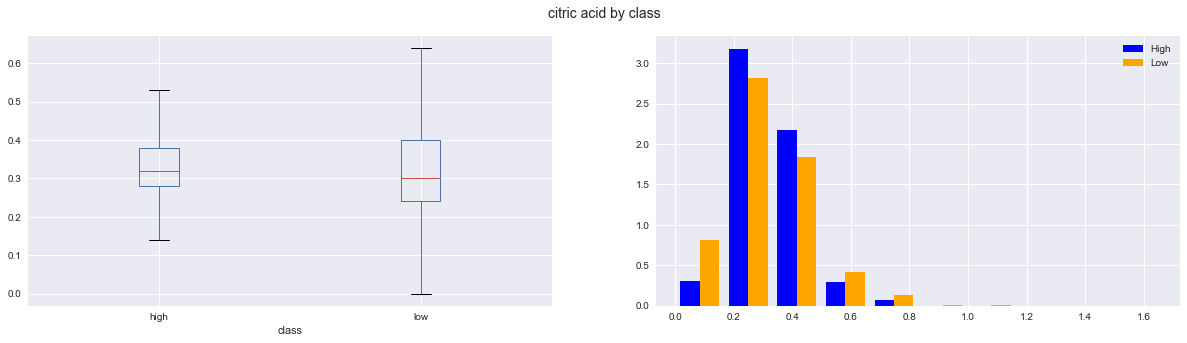

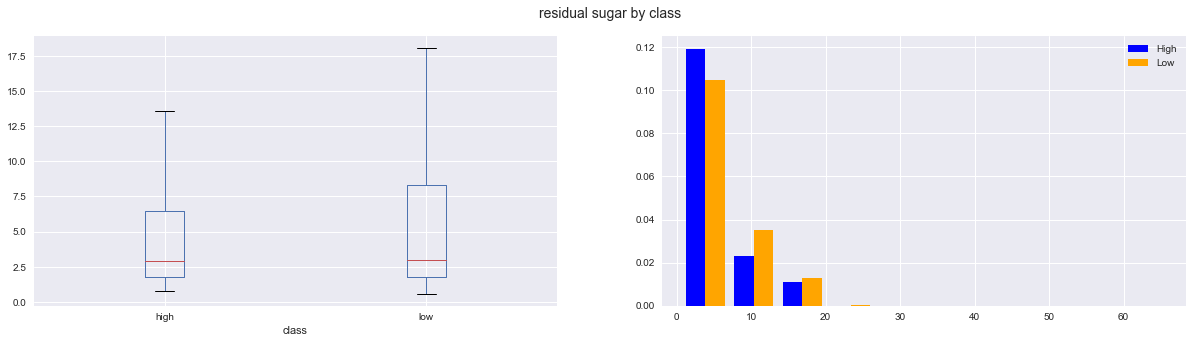

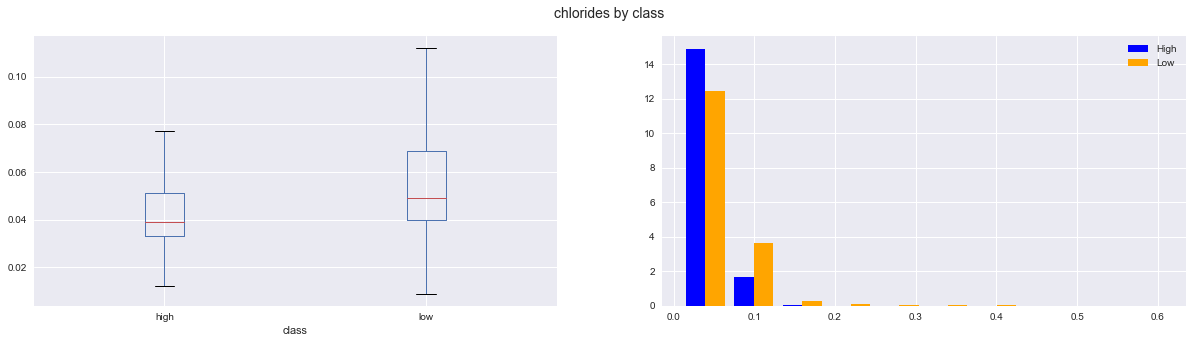

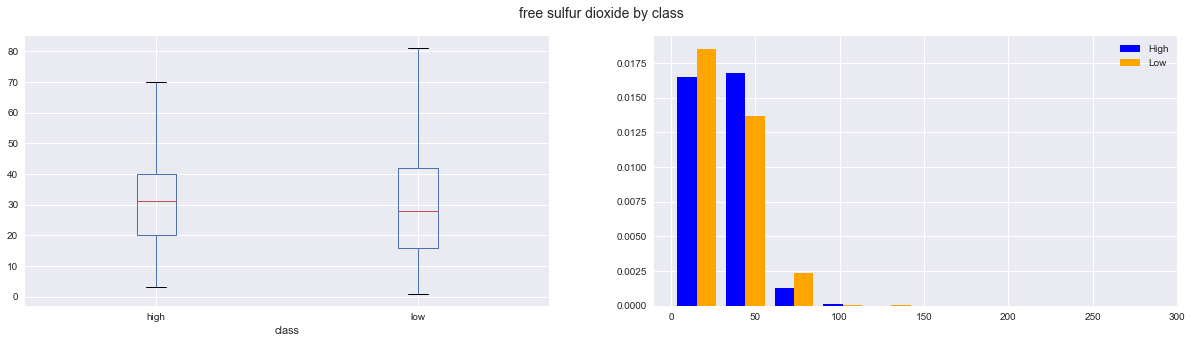

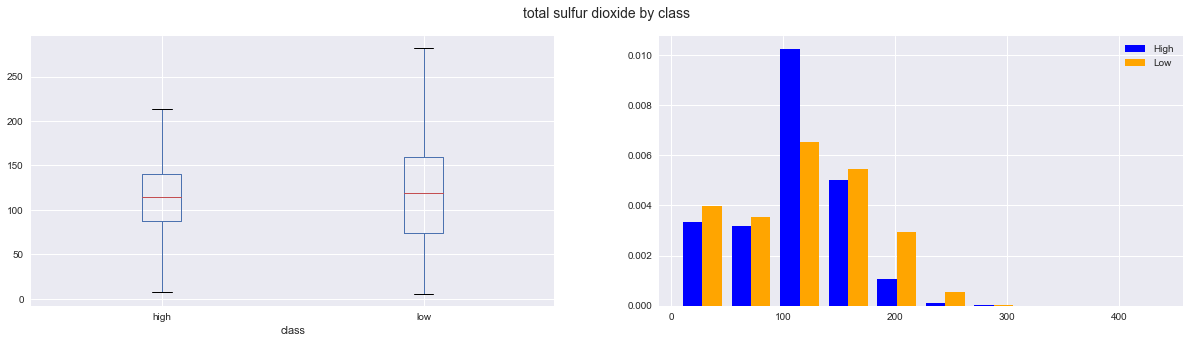

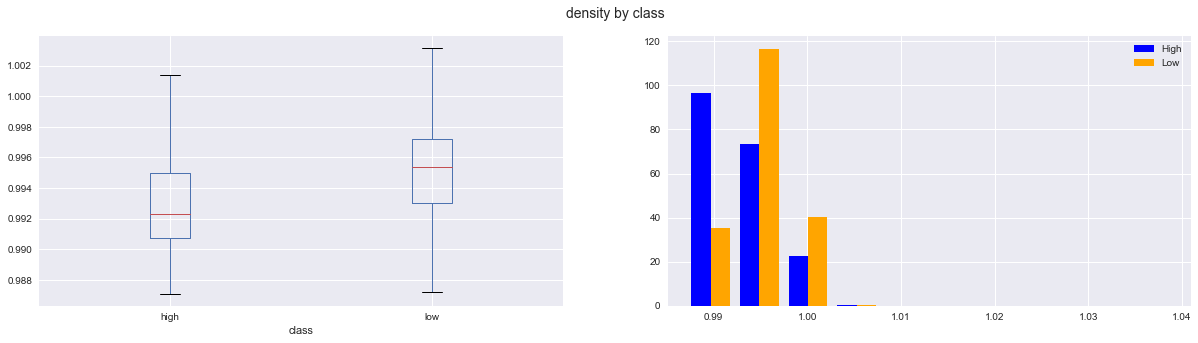

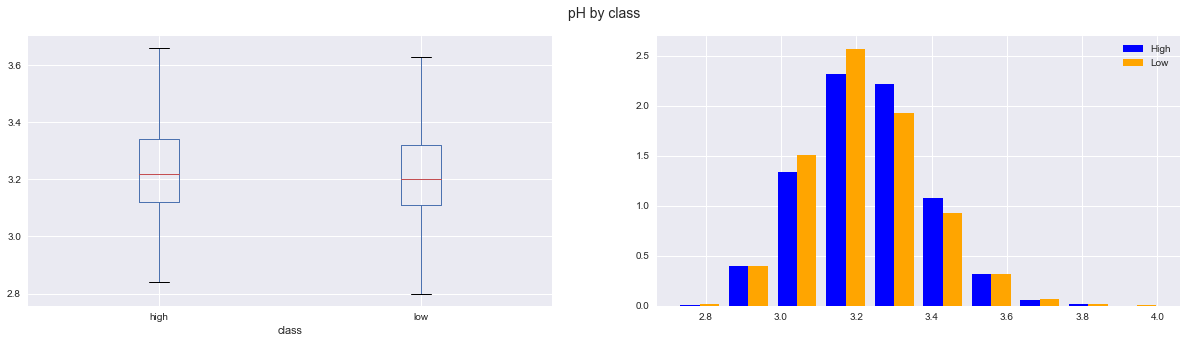

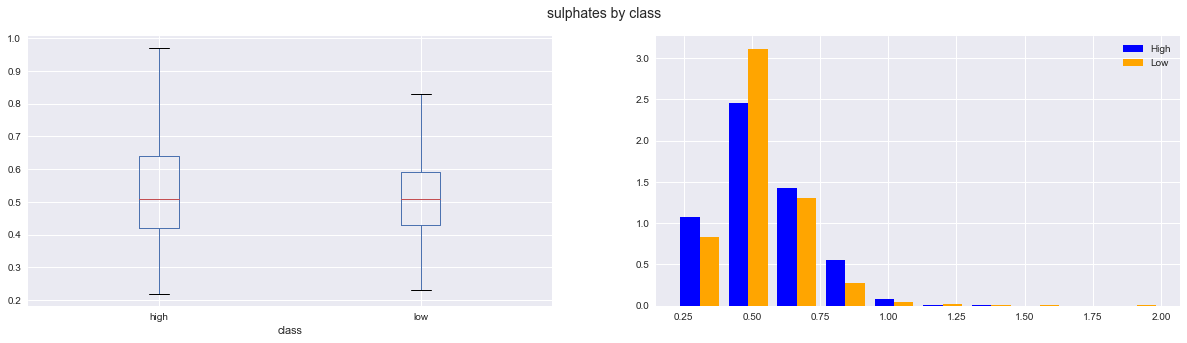

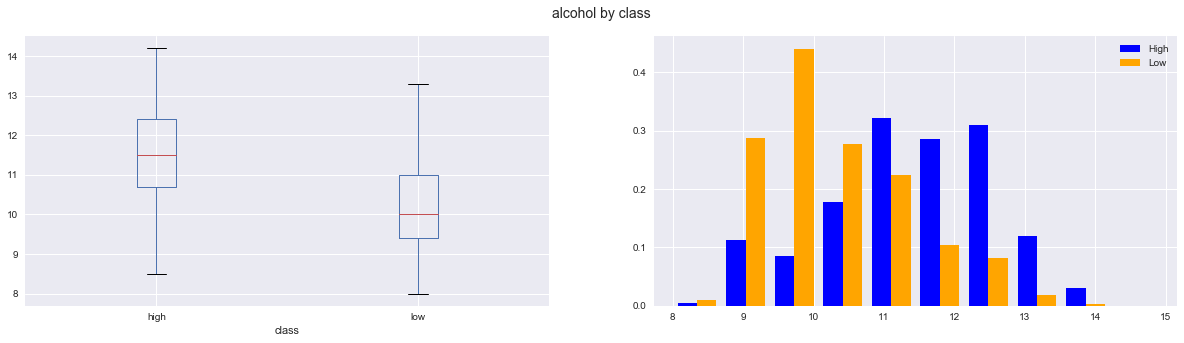

In [11]:
for column in df.columns.drop(['quality', 'color', 'class']):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 5))
    df.boxplot(column, 'class', ax=ax1, showfliers=False)
    ax1.set_title('')
    ax2.hist([df.loc[df['class'] == 'high', column], df.loc[df['class'] == 'low', column]], 
             label=['High', "Low"], color=['blue', 'orange'], normed=True)
    ax2.legend()
    fig.suptitle('{} by class'.format(column), fontsize=14)

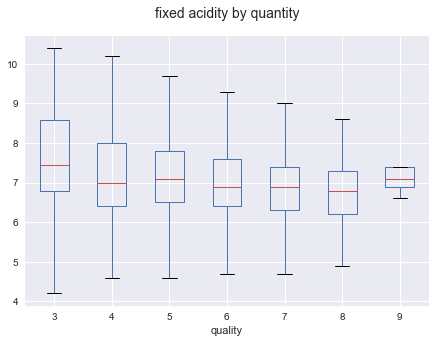

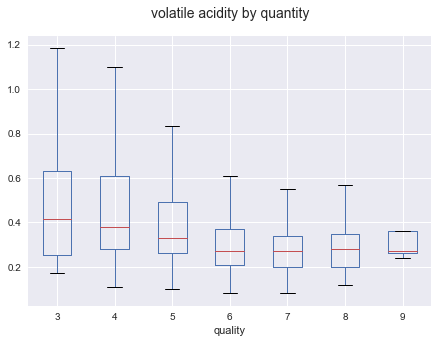

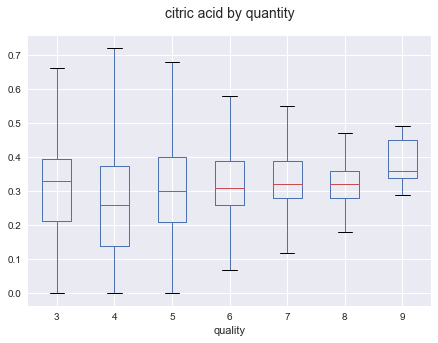

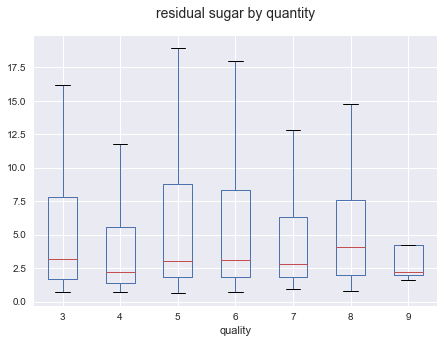

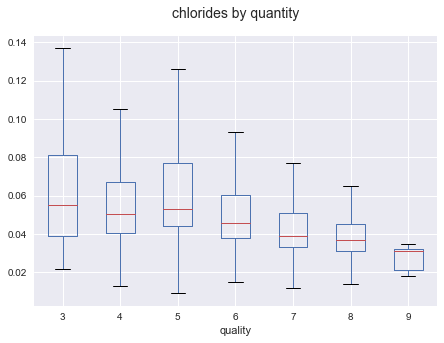

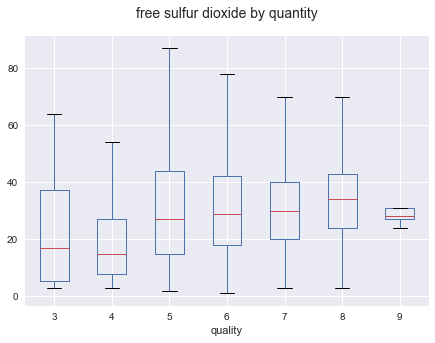

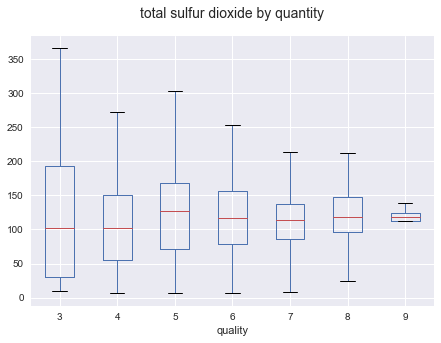

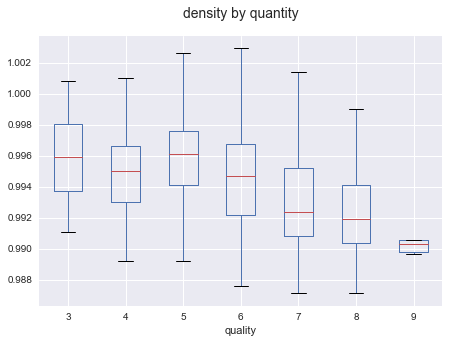

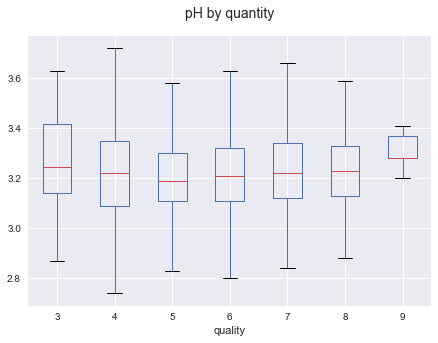

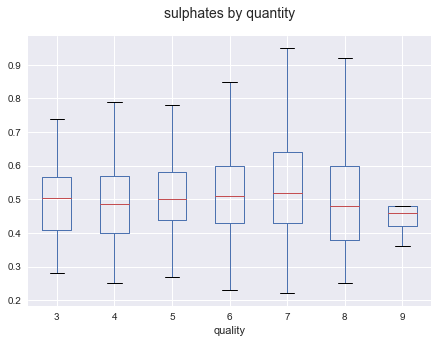

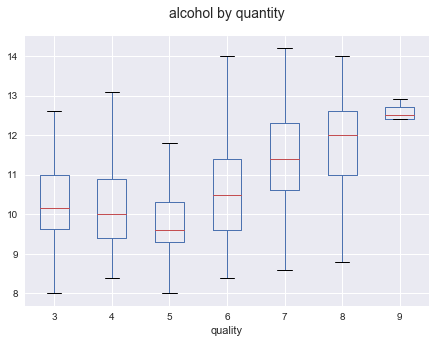

In [12]:
for column in df.columns.drop(['quality', 'color', 'class']):
    fig, ax = plt.subplots(figsize=(7,5))
    df.boxplot(column, 'quality', showfliers=False, ax=ax)
    ax.set_title('')
    fig.suptitle('{} by quantity'.format(column), fontsize=14)

## 4b. Correlation

In [13]:
df.corr().style.apply(background_gradient, axis=1) \
    .set_properties(**{'max-width': '120px', 'font-size': '12pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

## 4c. Predictors, most correlated with quality

In [14]:
vals = ['volatile acidity', 'chlorides', 'density', 'alcohol']
cc = combinations(vals, 2)

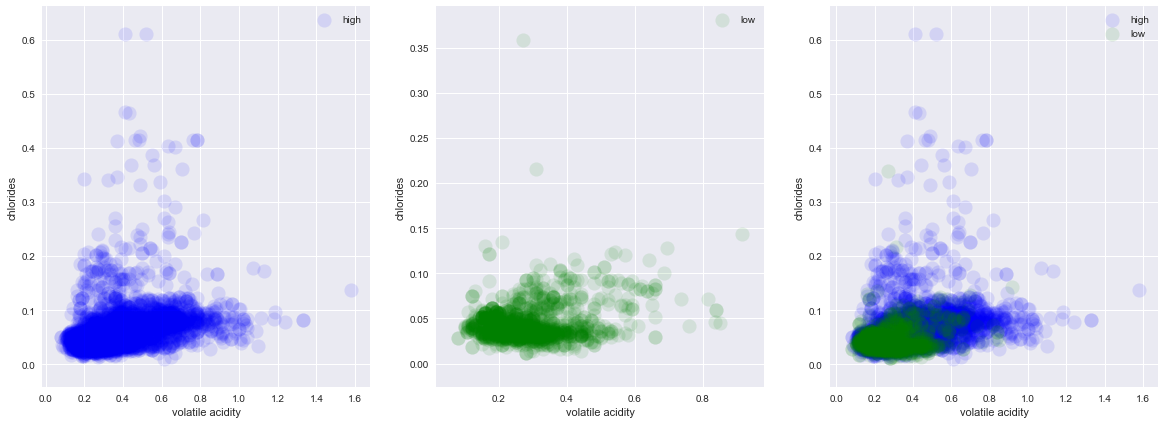

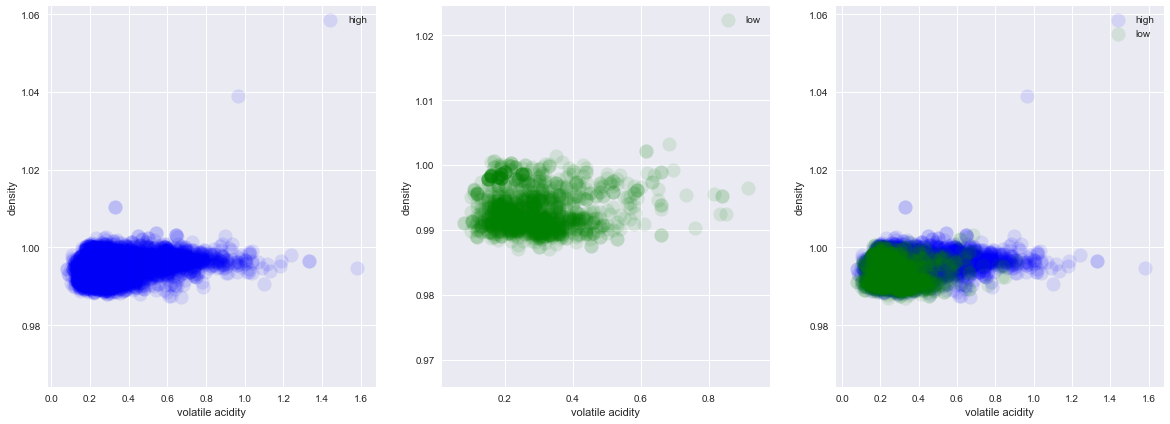

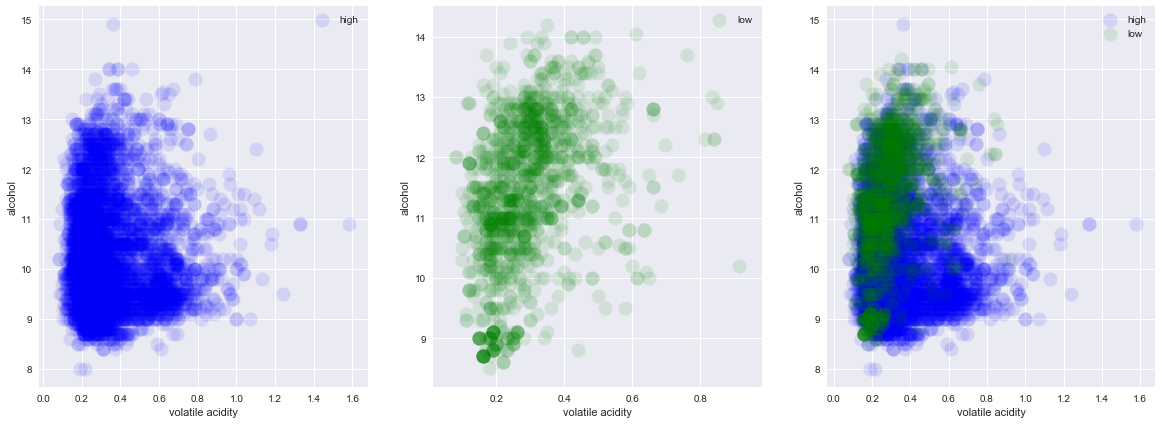

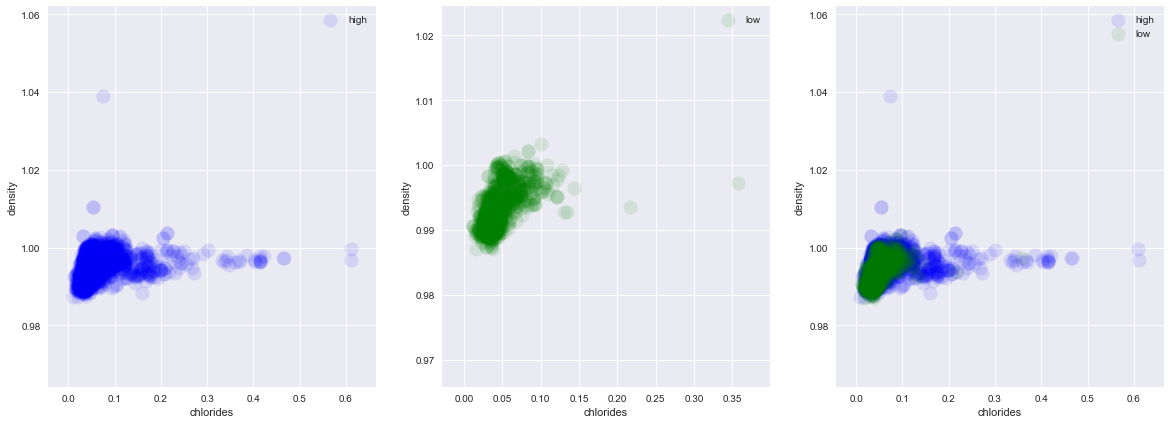

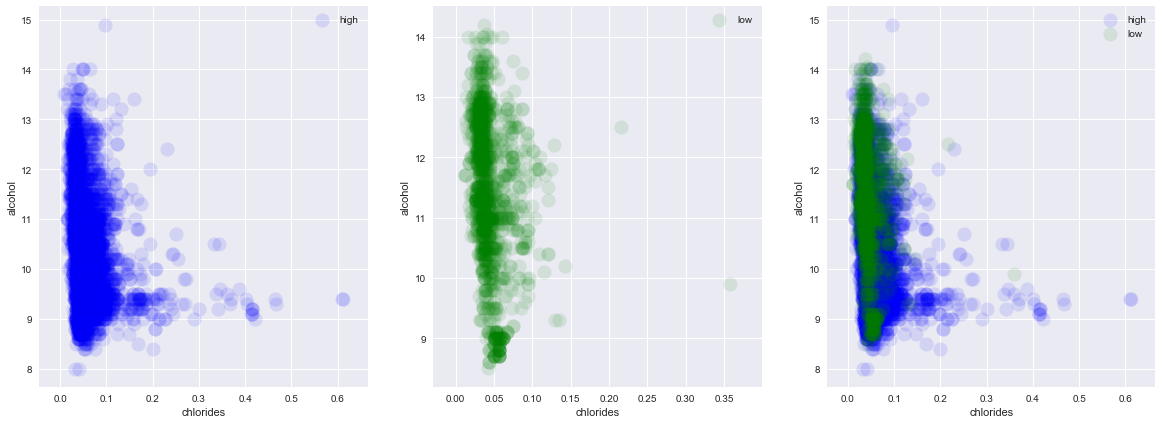

In [15]:
for k,v in combinations(vals, 2):
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 7))
    sns.regplot(k,v, data=df[df['class']=='low'], fit_reg=False,  color="blue",
               scatter_kws={'alpha':0.1, 's':200}, ax=ax1, label='high')
    ax1.legend(loc='best')
    sns.regplot(k,v, data=df[df['class']=='high'], fit_reg=False,  color="green",
               scatter_kws={'alpha':0.1, 's':200}, ax=ax2, label='low')
    ax2.legend(loc='best')
    sns.regplot(k,v, data=df[df['class']=='low'], fit_reg=False,  color="blue",
               scatter_kws={'alpha':0.1, 's':200}, ax=ax3, label='high')
    sns.regplot(k,v, data=df[df['class']=='high'], fit_reg=False, color="green",
               scatter_kws={'alpha':0.1, 's':200}, ax=ax3, label='low')
    ax3.legend(loc='best')

# Modelling

# 5. Classification

## 5.1. Binary

In [16]:
X_train, X_test, y_train, y_test = prepare_data(df.drop(['class', 'color', 'quality'], axis=1).as_matrix(), df['class'].values)

### Logistic Regression

In [17]:
Image(filename='img/lg1.png', width='100%')

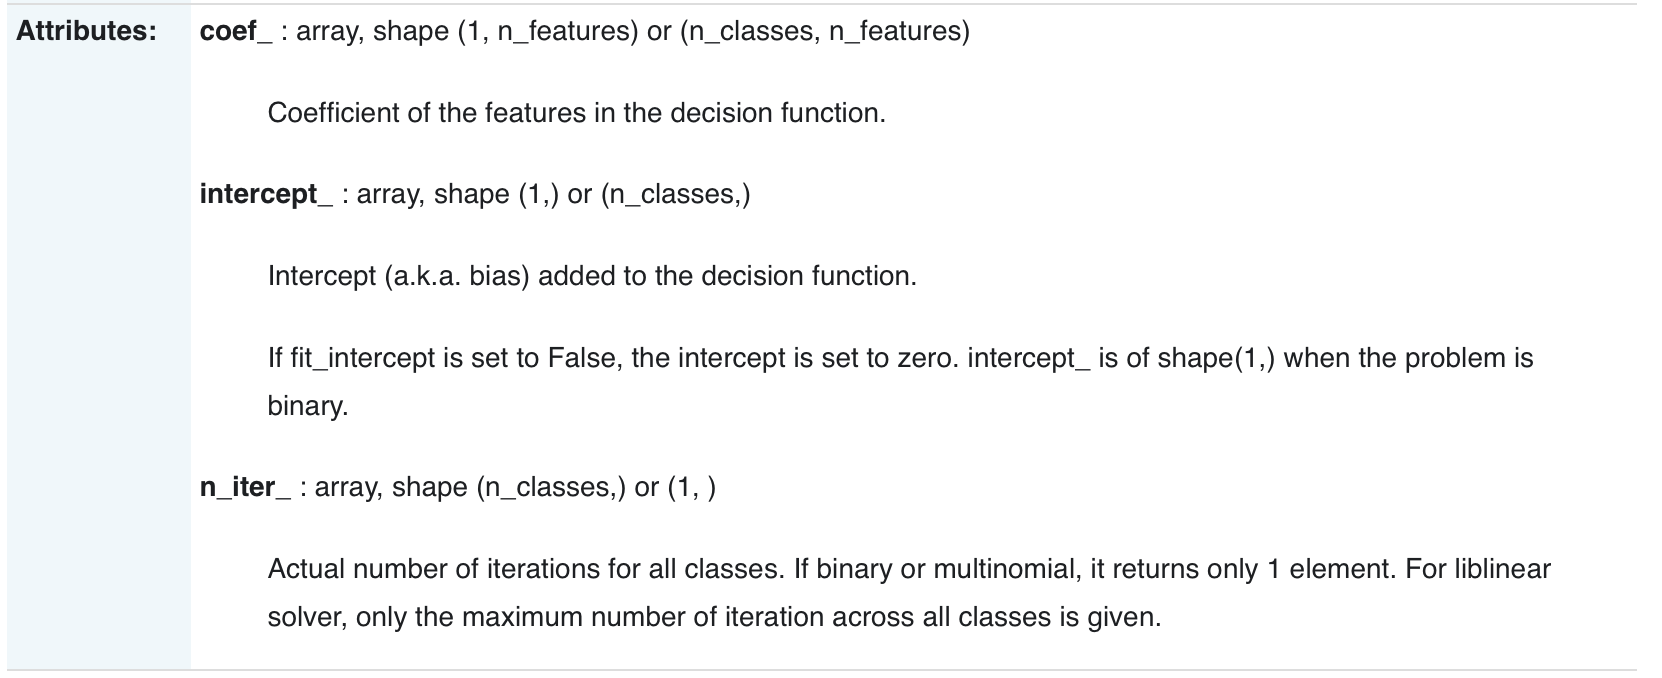

In [18]:
Image(filename='img/lg2.png', width='100%')


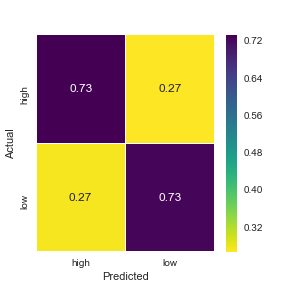

In [19]:
lr_model = LogisticRegression(class_weight="balanced")
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)
HTML(evaluate_classification(y_test, lr_pred, pos_label="high",
sample_weight=compute_sample_weight('balanced', y=y_test)))

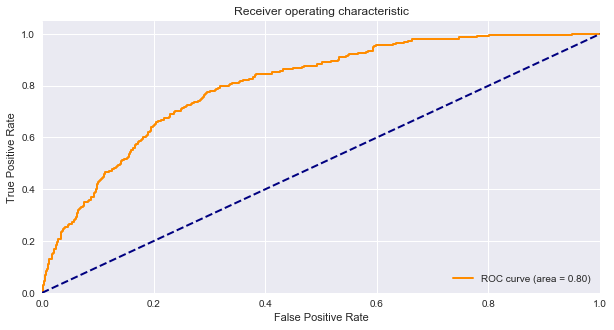

In [20]:
plot_roc_single(y_test, lr_model.predict_proba(X_test)[:,0], labels={'high': 1, 'low': 0})

## Decision Tree

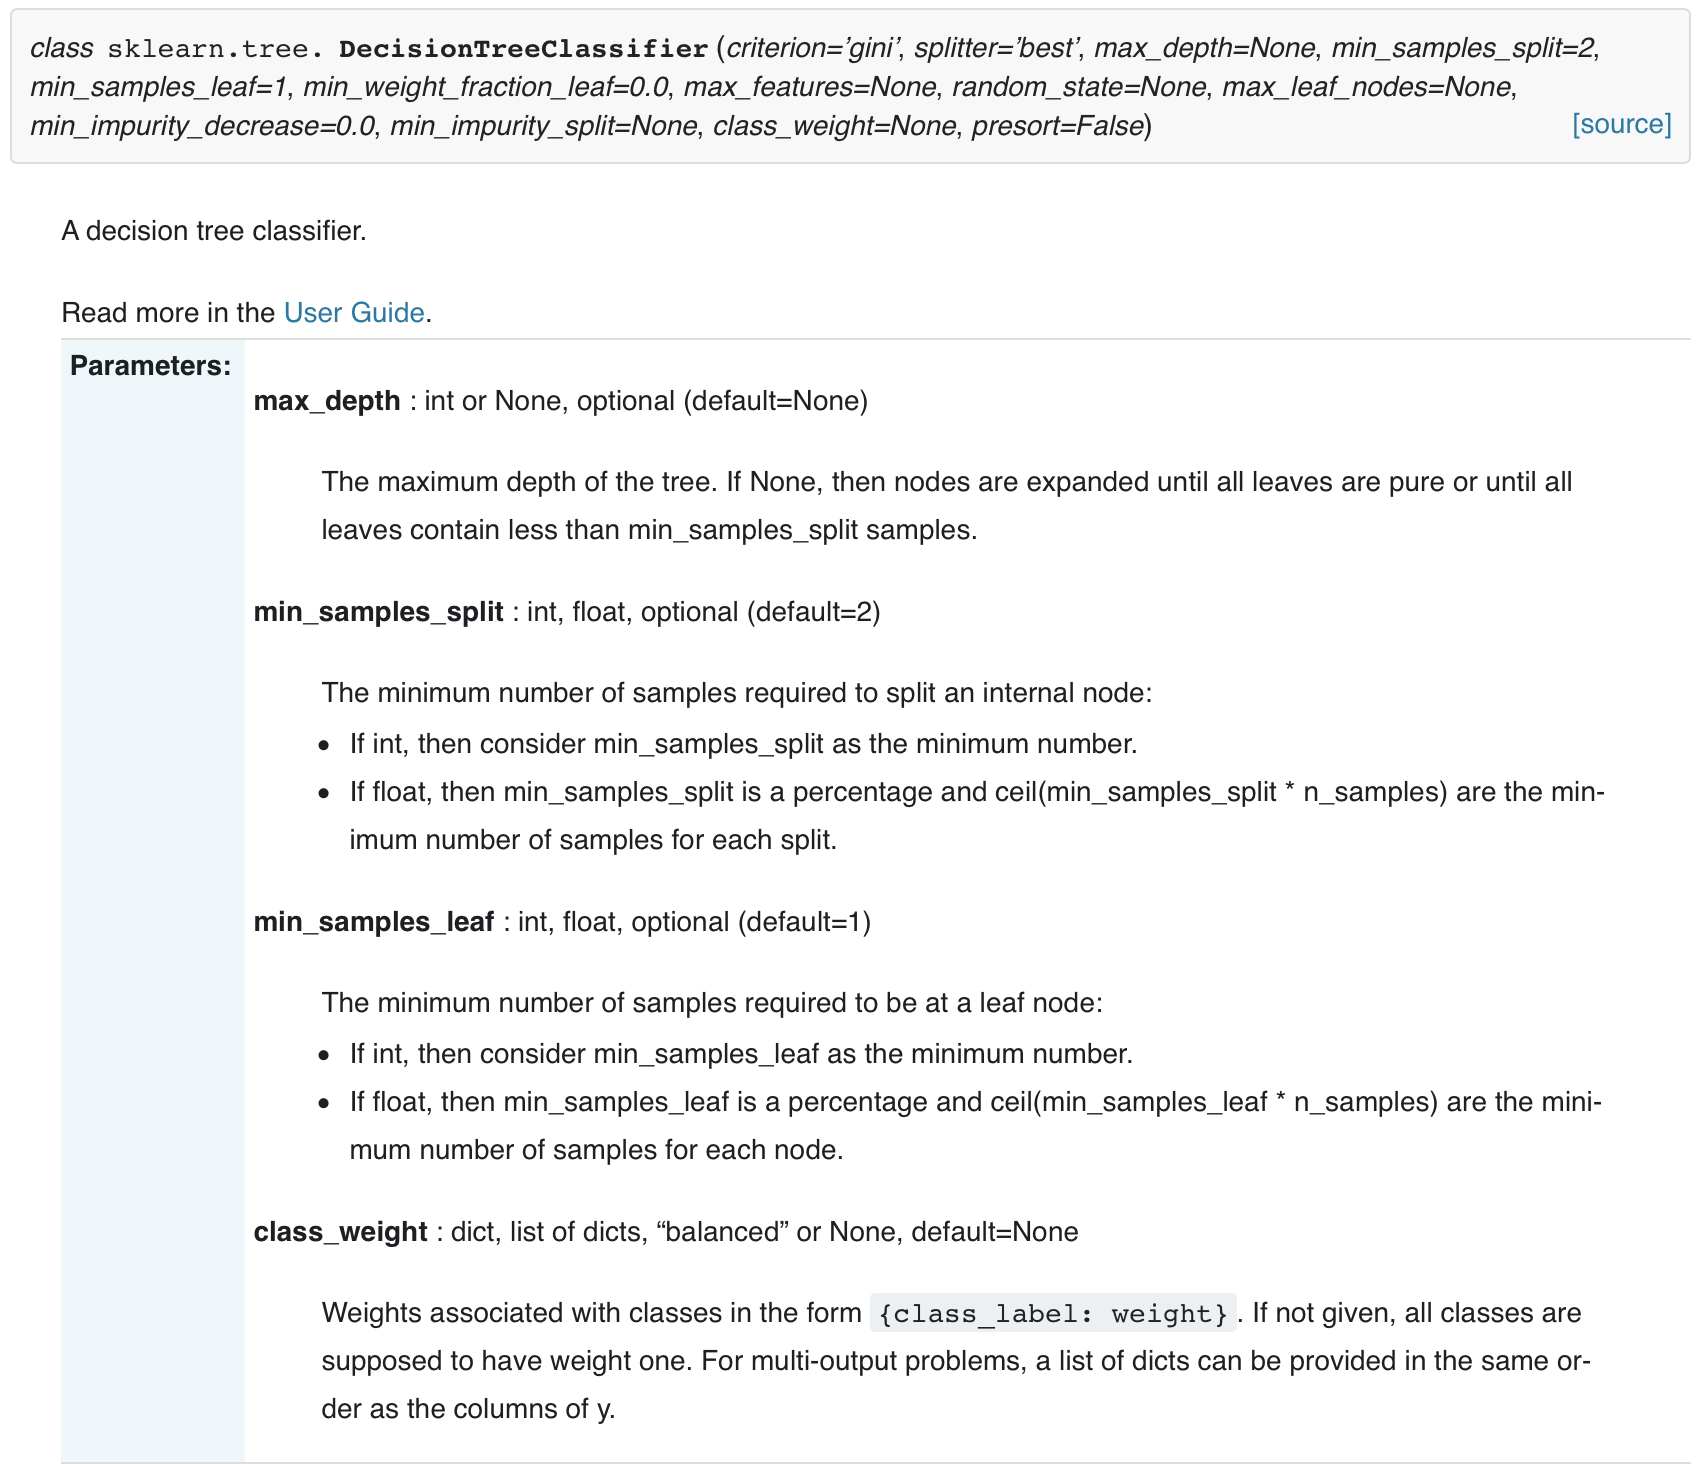

In [21]:
Image(filename='img/df1.png', width='100%')

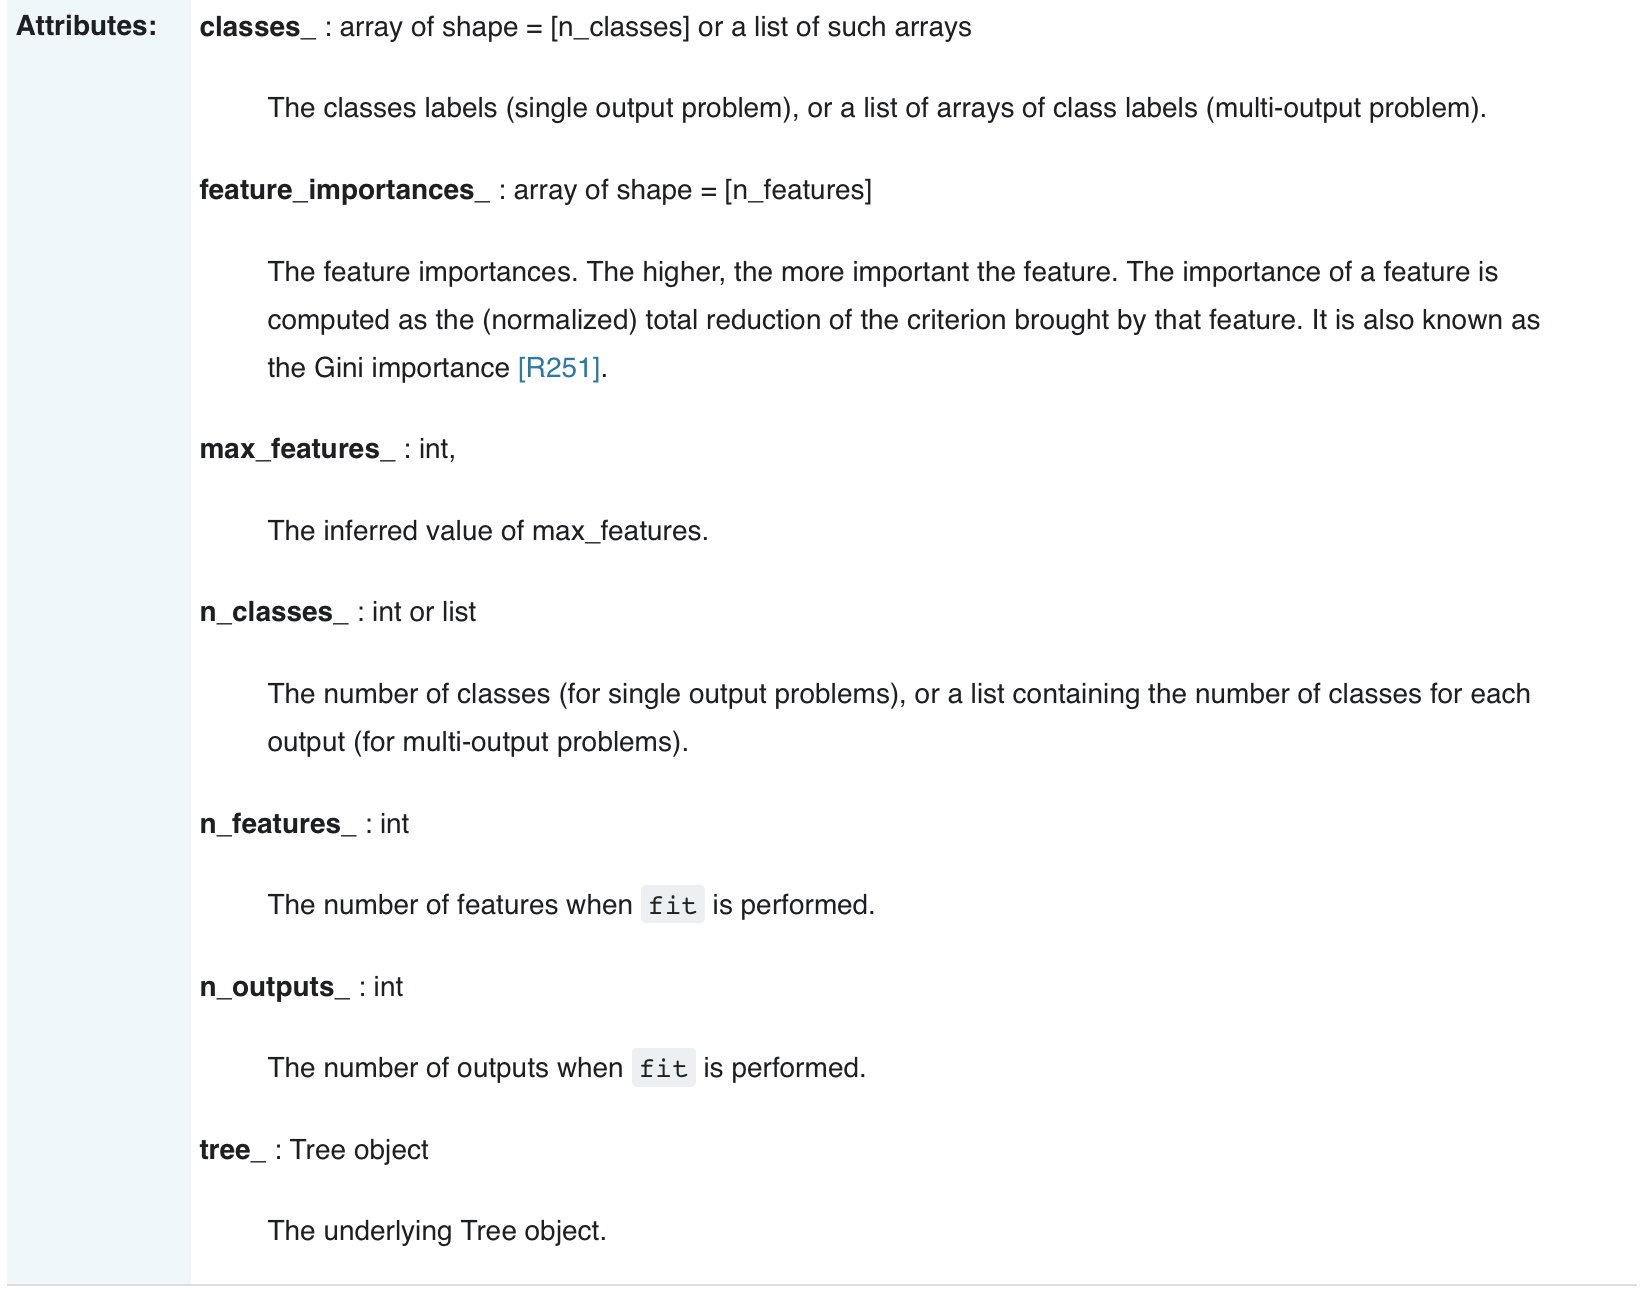

In [22]:
Image(filename='img/df2.png', width='100%')


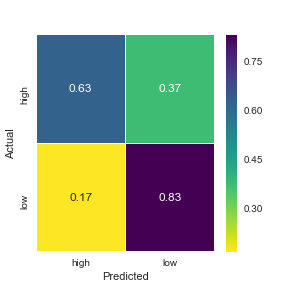

In [23]:
dt_model = DecisionTreeClassifier(class_weight="balanced", min_samples_leaf=3)
#sw=compute_sample_weight('balanced', y=y_train)
#sw[sw>1]=sw[sw>1]**15
sw1=compute_sample_weight('balanced', y=y_test)

dt_model.fit(X_train, y_train)#, sample_weight=sw)
dt_pred = dt_model.predict(X_test)
HTML(evaluate_classification(y_test, dt_pred, pos_label="high", sample_weight=sw1))

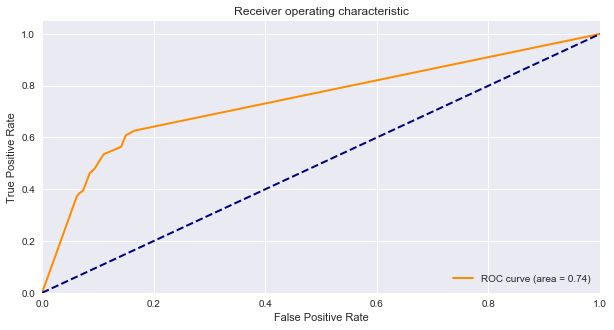

In [24]:
plot_roc_single(y_test, dt_model.predict_proba(X_test)[:,0], labels={'high': 1, 'low': 0})

## K-NN

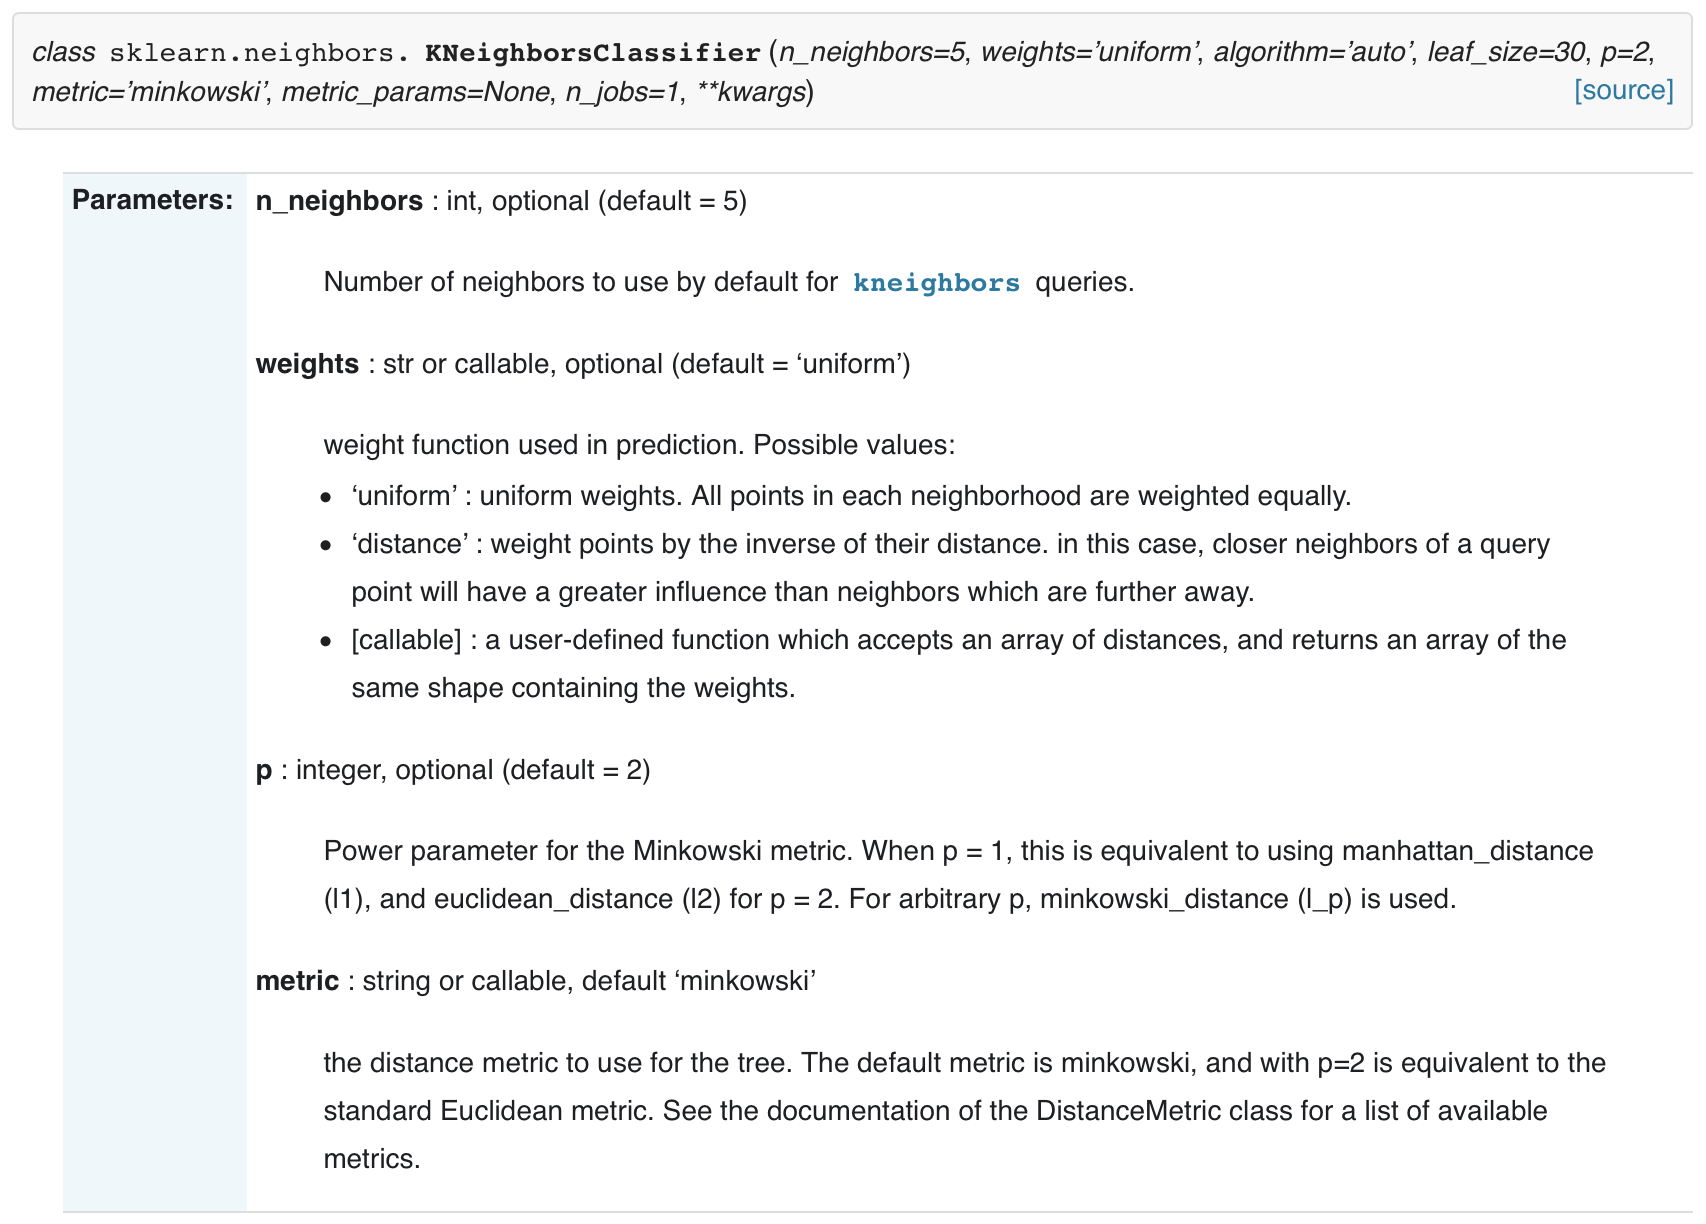

In [25]:
Image(filename='img/knn.png', width='100%')


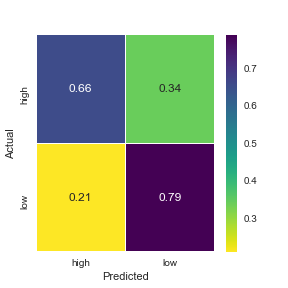

In [26]:
knn_model = KNeighborsClassifier(n_neighbors=2,  algorithm="brute" )
knn_model.fit(X_train, y_train)
knn_pred = knn_model.predict(X_test)
sw1=compute_sample_weight('balanced', y=y_test)
HTML(evaluate_classification(y_test, knn_pred, pos_label="high", sample_weight=sw1))

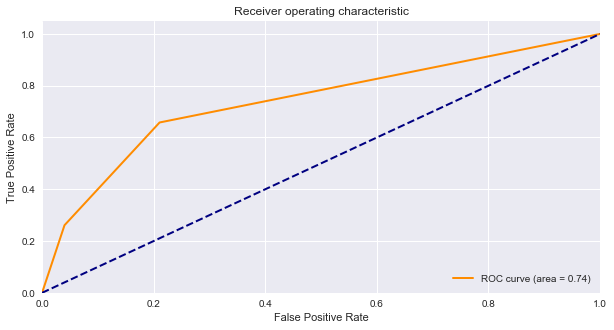

In [27]:
plot_roc_single(y_test, knn_model.predict_proba(X_test)[:,0], labels={'high': 1, 'low': 0})

## 5.2. Multi-class

In [28]:
def convert_to_multiclass(x):
    if x == 3 or x == 4 or x == 5 :
        return "low"
    elif  x == 6:
        return "medium"
    else:
        return "high"

df['class'] = df.quality.apply(convert_to_multiclass)

In [29]:
df['class'].value_counts()

medium    2836
low       2384
high      1277
Name: class, dtype: int64

In [30]:
X_train, X_test, y_train, y_test = prepare_data(df.drop(['class', 'color', 'quality'], axis=1).as_matrix(), df['class'].values)

## Logistic Regression


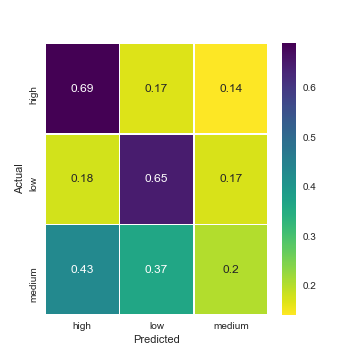

In [31]:
lr_model = LogisticRegression(multi_class="multinomial", solver="lbfgs", class_weight="balanced", max_iter=100)
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)
HTML(evaluate_classification(y_test, lr_pred, average="macro", fs=5))

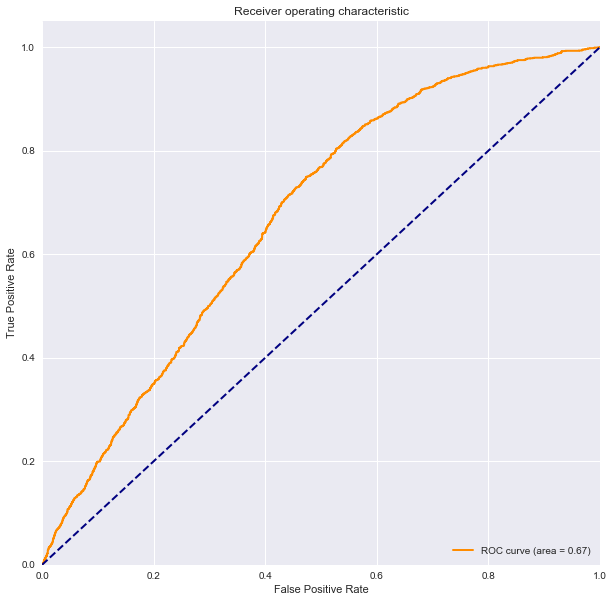

In [32]:
plot_roc_single(pd.get_dummies(y_test).as_matrix(), lr_model.decision_function(X_test), fsize=[10,10])

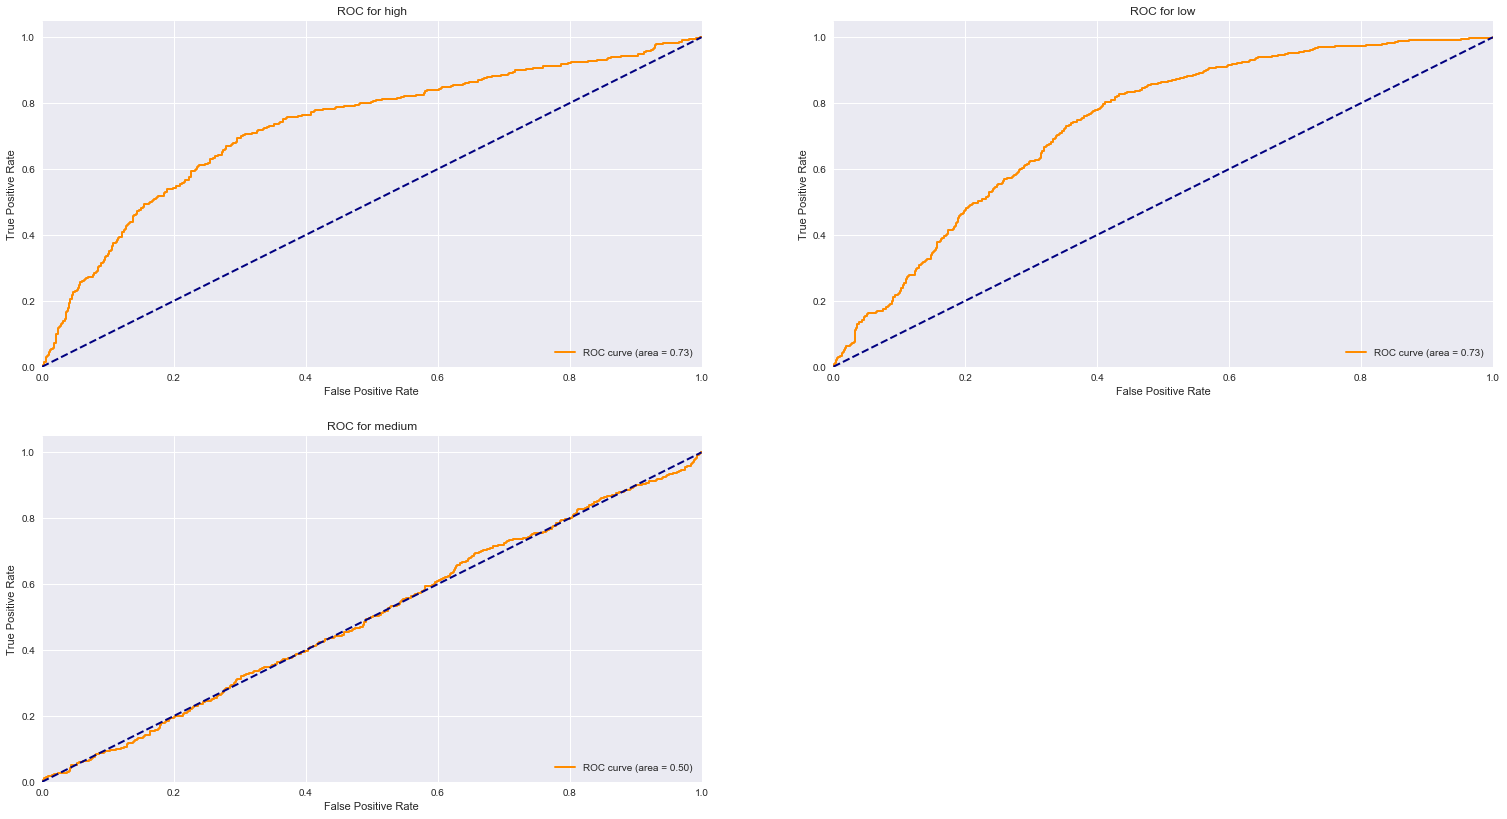

In [33]:
plot_roc_multiple(pd.get_dummies(y_test).as_matrix(), lr_model.decision_function(X_test), titles=np.unique(y_test))

### Decision Tree


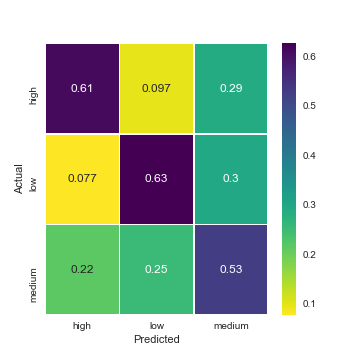

In [34]:
dt_model = DecisionTreeClassifier(class_weight="balanced", 
                                  min_samples_leaf=3, 
                                  criterion='gini')
dt_model.fit(X_train, y_train)
dt_pred = dt_model.predict(X_test)
HTML(evaluate_classification(y_test, dt_pred, average="micro", fs=5))

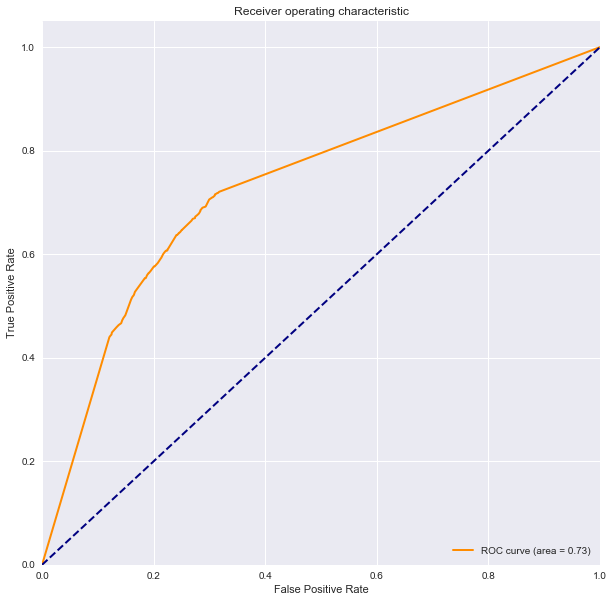

In [35]:
plot_roc_single(pd.get_dummies(y_test).as_matrix(), dt_model.predict_proba(X_test), fsize=[10,10])

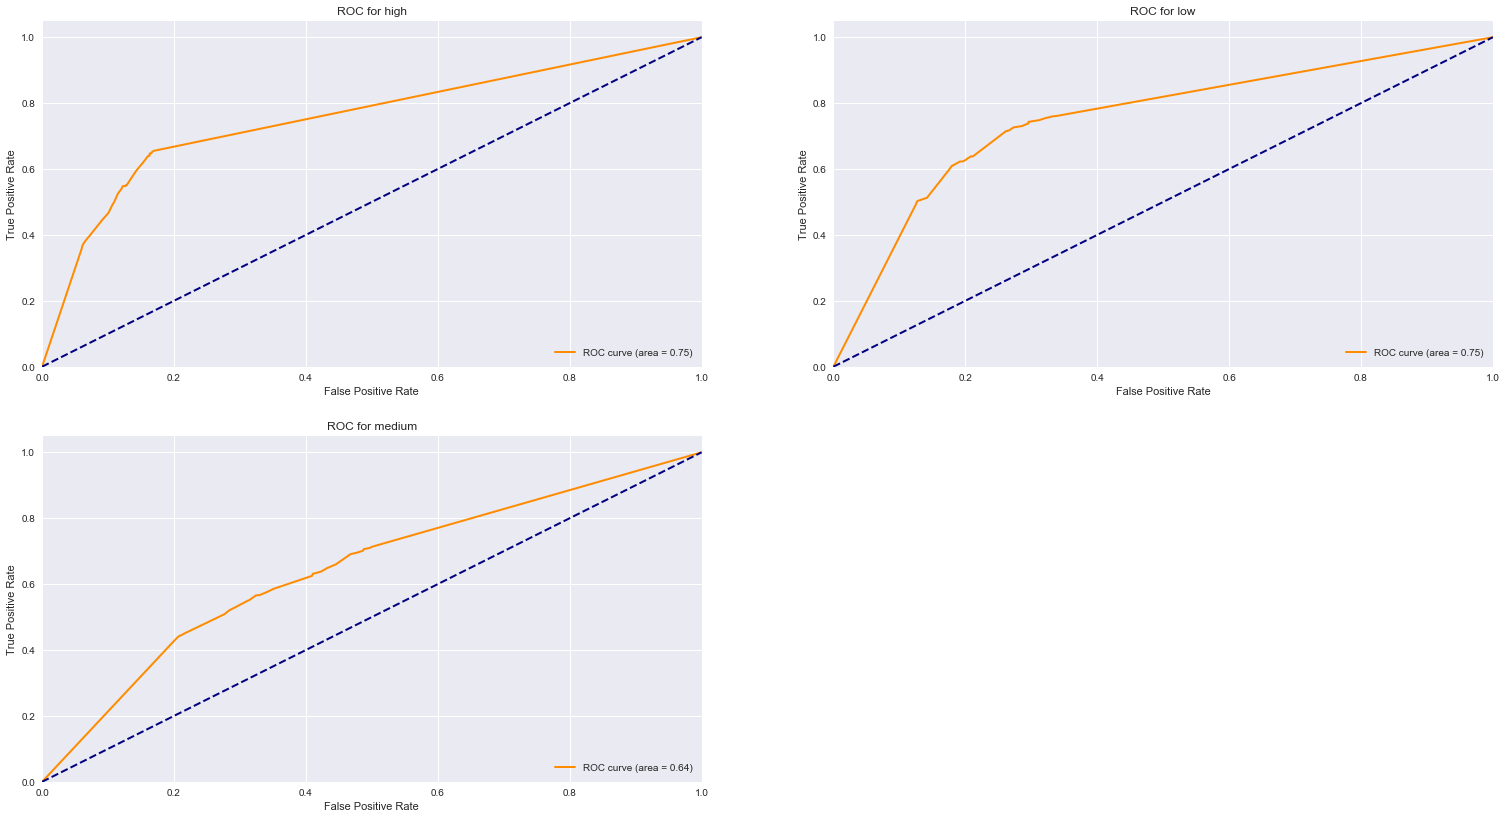

In [36]:
plot_roc_multiple(pd.get_dummies(y_test).as_matrix(), dt_model.predict_proba(X_test), titles=np.unique(y_test))

### K-NN


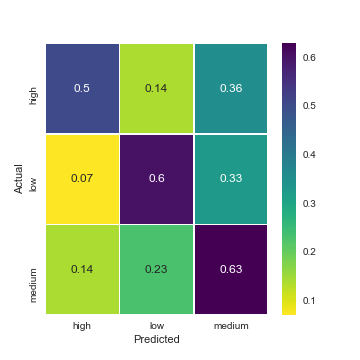

In [37]:
knn_model = KNeighborsClassifier(n_neighbors=5, 
                                 algorithm='brute', 
                                 weights='distance', 
                                 metric='cosine')
knn_model.fit(X_train, y_train)
knn_pred = knn_model.predict(X_test)
HTML(evaluate_classification(y_test, knn_pred, average="macro", fs=5))

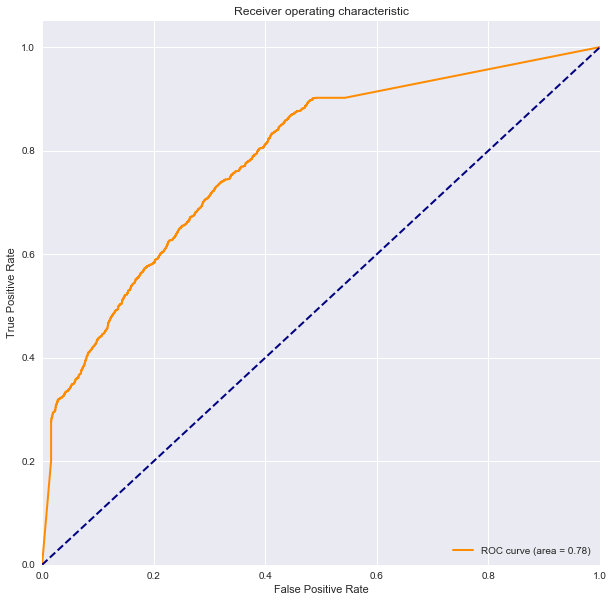

In [38]:
plot_roc_single(pd.get_dummies(y_test).as_matrix(), knn_model.predict_proba(X_test), fsize=[10,10])

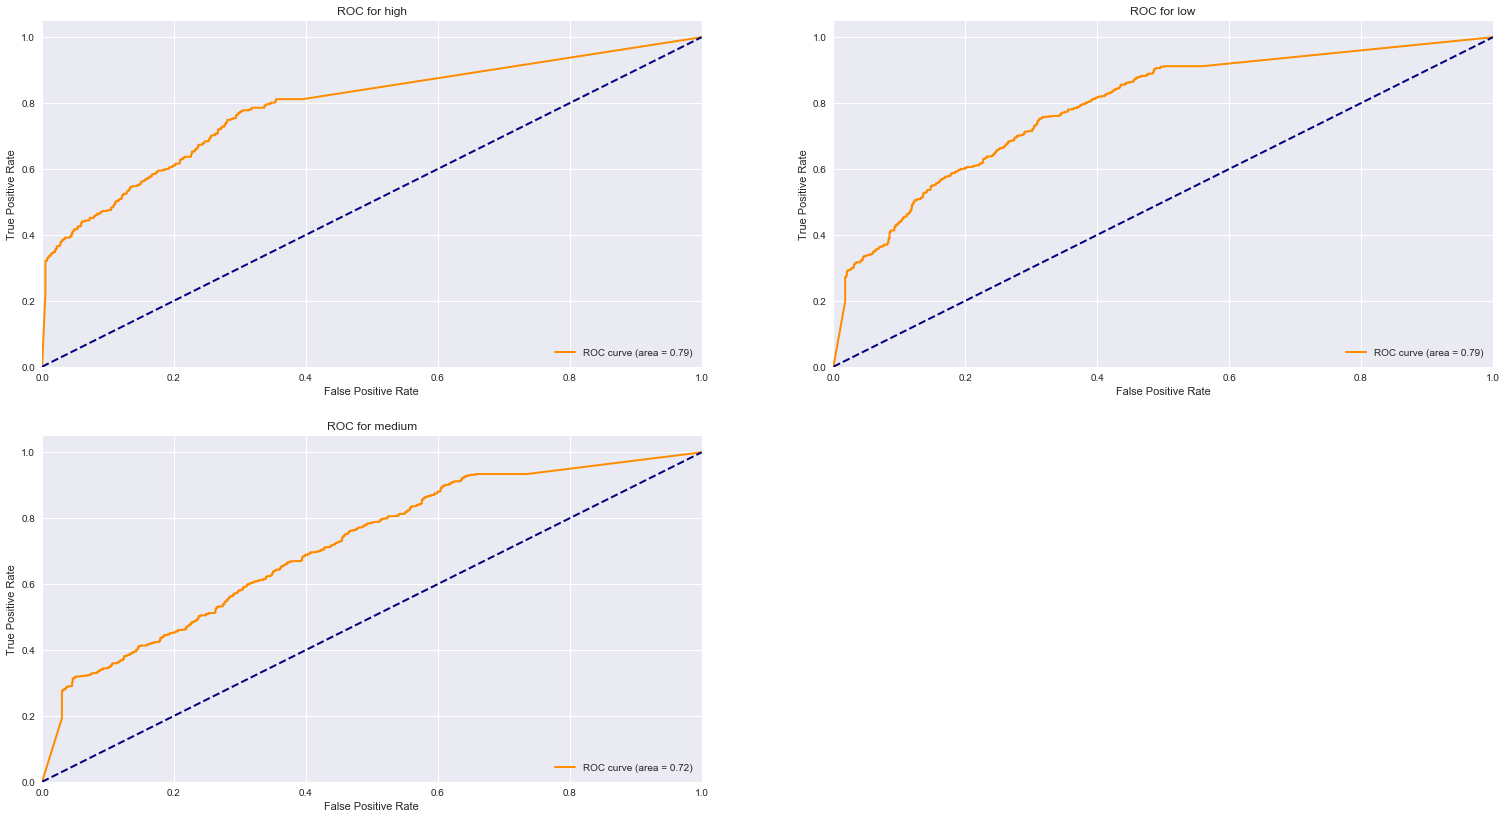

In [39]:
plot_roc_multiple(pd.get_dummies(y_test).as_matrix(), knn_model.predict_proba(X_test), titles=np.unique(y_test))

## Ensemble

Ensembling approaches train several classifiers in the hope that combining their predictions will outperform any single classifier (worst case scenario, be better than the worse classifier). The combination rule can be: majority vote, mean, max, min, product … the average rule is the most used. You can read more https://mlwave.com/kaggle-ensembling-guide/

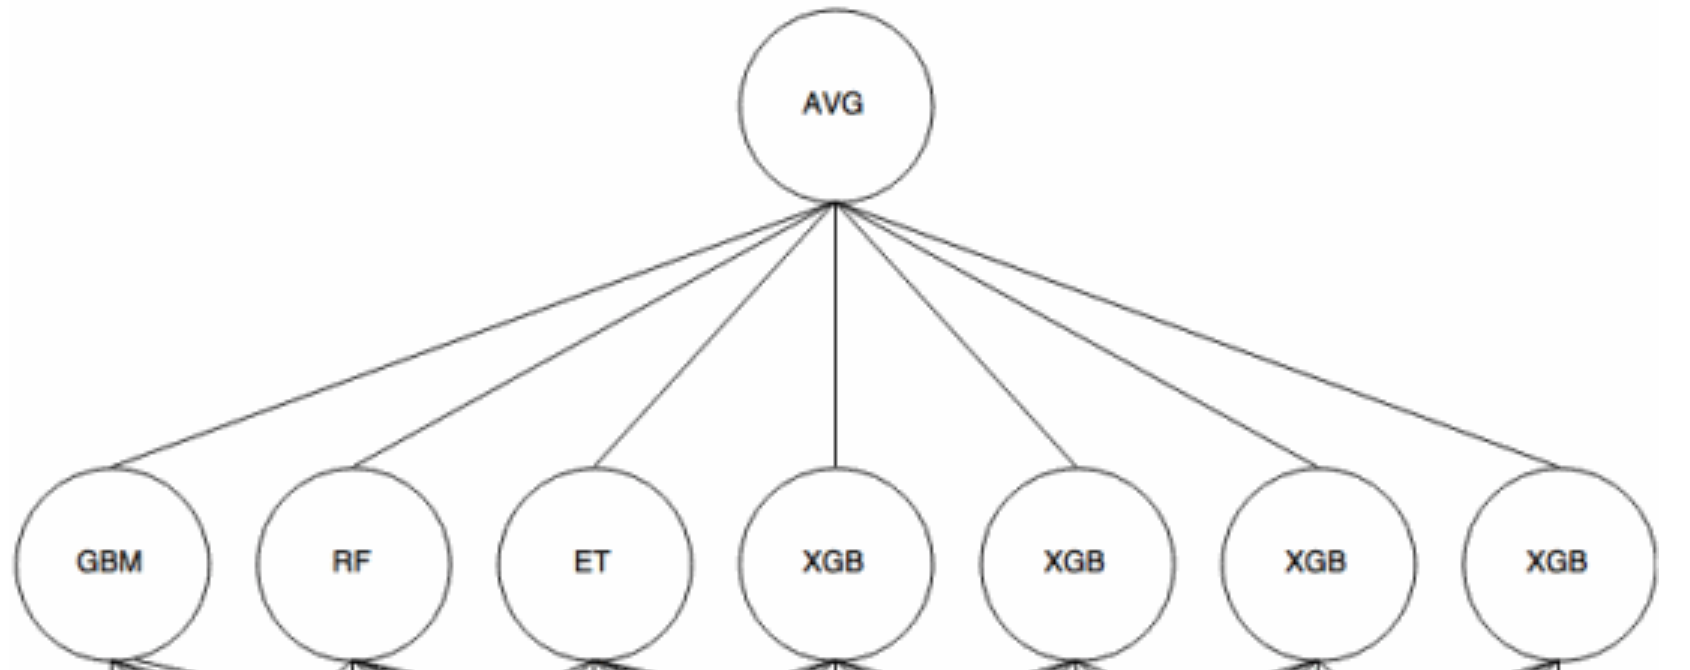

In [40]:
Image(filename='img/ensemble.png', width='100%')

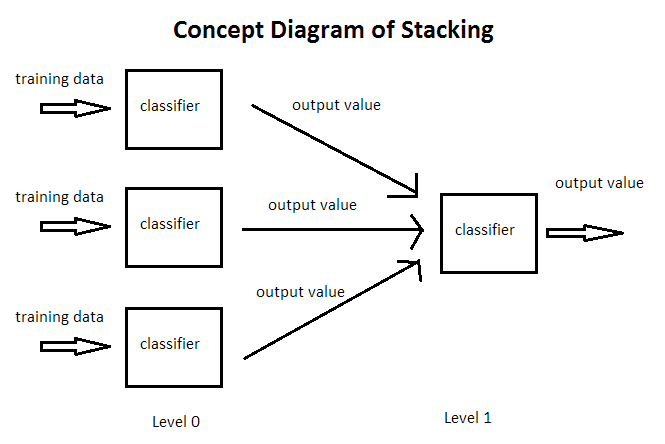

In [41]:
Image(filename='img/ensemble_stack.png', width='100%')

In [42]:
def f(x):
    dc=np.array(['high','low','medium'])
    pred_pr=dt_pred*x[0]+knn_pred*x[1]+lr_pred*x[2]
    pred=pred_pr.argmax(axis=1)
    m=np.array(confusion_matrix_simple(y_test,pred))
    return (1-m.diagonal().min())
def opt():
    acc=[]
    X=[]
    for k in range(20):
        x0=k/20.0
        for k1 in range(20-k-1):
            x1=k1/20.0
            x2=1-x0-x1
            acc.append(f([x0,x1,x2]))
            X.append([x0,x1,x2])
            
    return(acc, X)
    

Best coefficients: [0.2, 0.45, 0.35000000000000003]



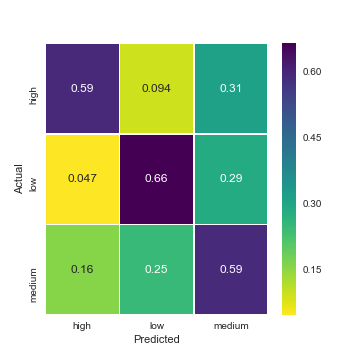

In [43]:
dc=np.array(['high','low','medium'])

knn_pred = knn_model.predict_proba(X_test)
dt_pred=dt_model.predict_proba(X_test)
lr_pred = lr_model.predict_proba(X_test)

res, coeff =opt()
res=np.array(res)
cf=coeff[res.argmin()]
pred_pr=(dt_pred*cf[0]+knn_pred*cf[1]+lr_pred*cf[2])
pred=pred_pr.argmax(axis=1)

pred=dc[pred]
print('Best coefficients:', cf)
HTML(evaluate_classification(y_test, pred, average="macro", fs=5))

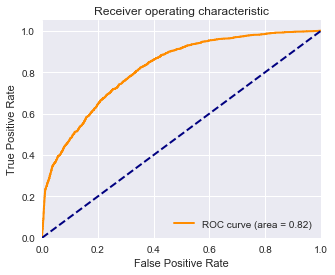

In [44]:
plot_roc_single(pd.get_dummies(y_test).as_matrix(), pred_pr, fsize=[5,4])

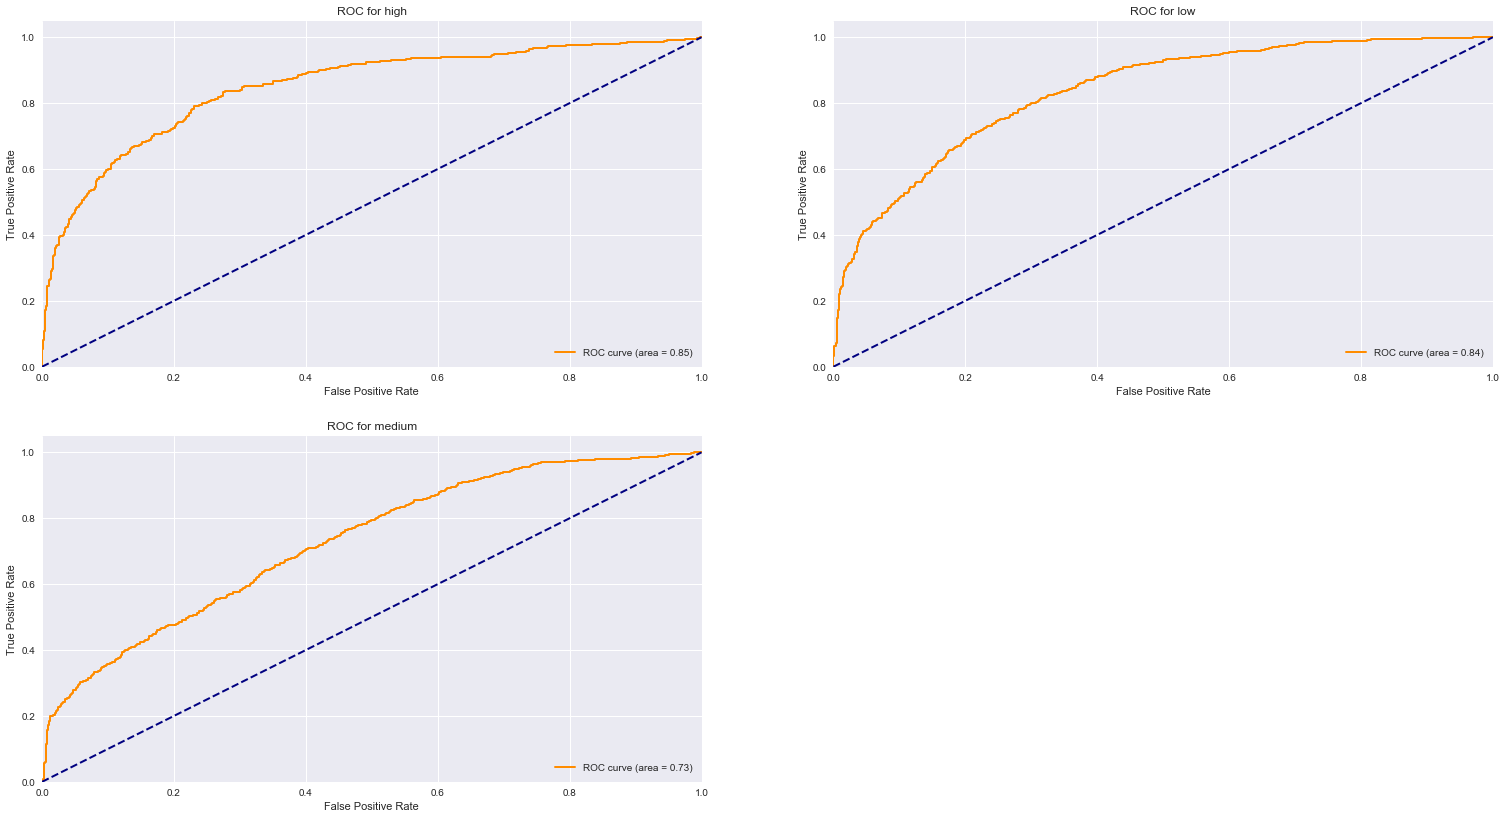

In [45]:
plot_roc_multiple(pd.get_dummies(y_test).as_matrix(), pred_pr, titles=np.unique(y_test))

## Tuning parameters in KNN model

In [46]:
from sklearn.grid_search import GridSearchCV

/usr/local/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


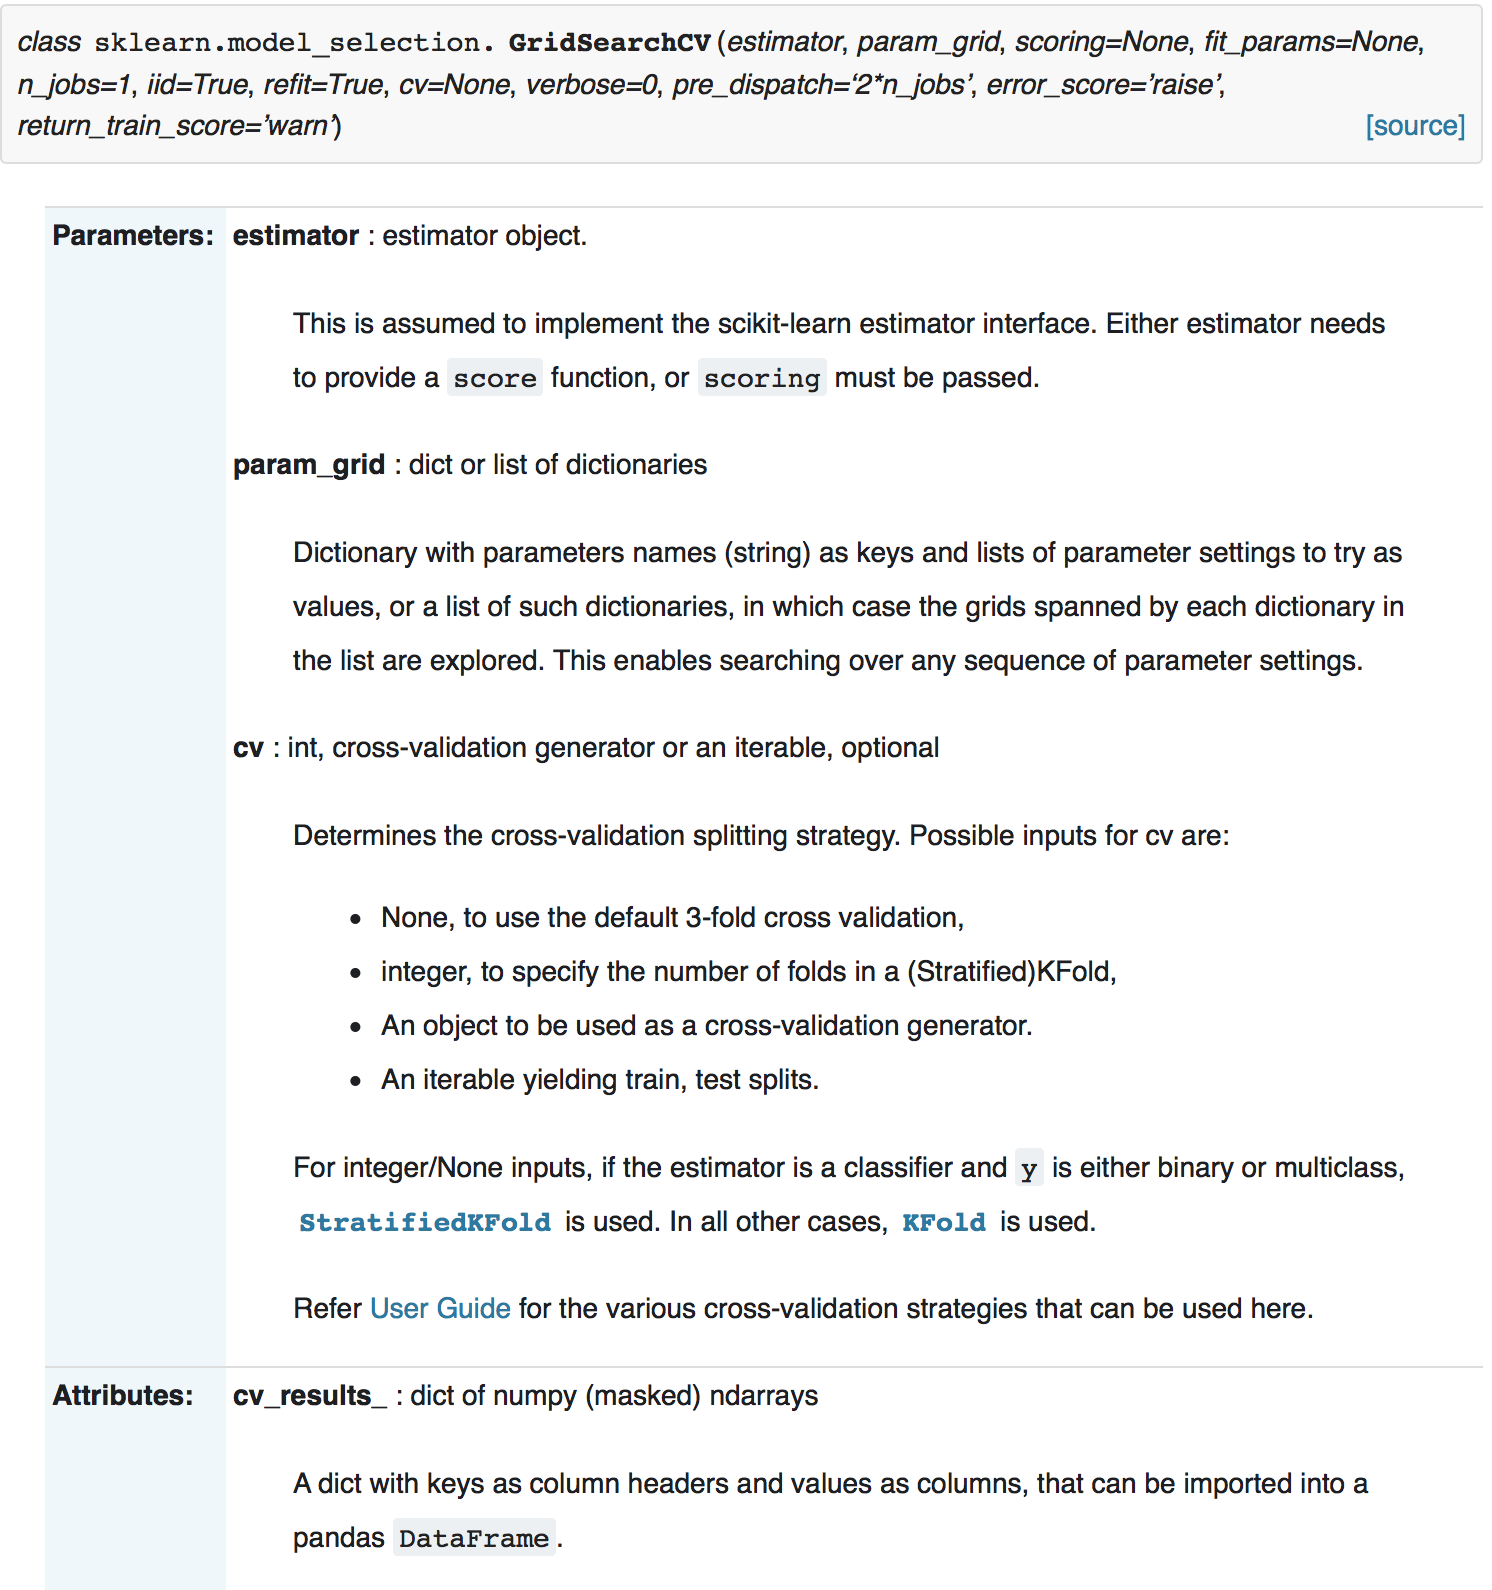

In [47]:
Image(filename='img/gs_cv.png', width='100%')


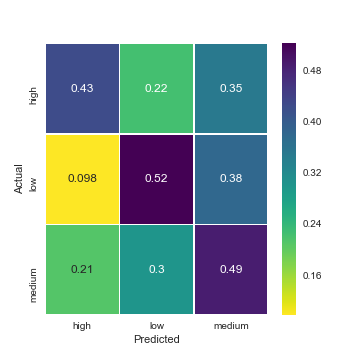

In [50]:
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)
knn_pred = knn_model.predict(X_test)
HTML(evaluate_classification(y_test, knn_pred, average="macro", fs=5))

In [48]:
X_train, X_test, y_train, y_test = prepare_data(df.drop(['class', 'color', 'quality'], axis=1).as_matrix(), df['class'].values)

knn_params = {'weights': ["uniform", 'distance'],
            'metric': ['cosine','minkowski'],
            'n_neighbors': np.arange(2, 8, 1),
            'algorithm' : ['auto', 'brute']
    }

clf_knn = GridSearchCV(KNeighborsClassifier(), knn_params, cv=3, verbose=1)
clf_knn.fit(X_train, y_train)
print('Best parameters:', clf_knn.best_params_)
knn_tune_pred = clf_knn.predict(X_test)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best parameters: {'algorithm': 'auto', 'metric': 'cosine', 'n_neighbors': 4, 'weights': 'distance'}


[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed:    9.1s finished



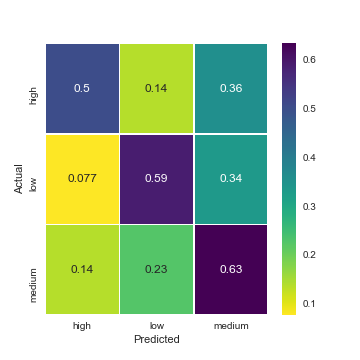

In [49]:
HTML(evaluate_classification(y_test, knn_tune_pred, average="macro", fs=5))

## Tuning parameters in DecisionTree model


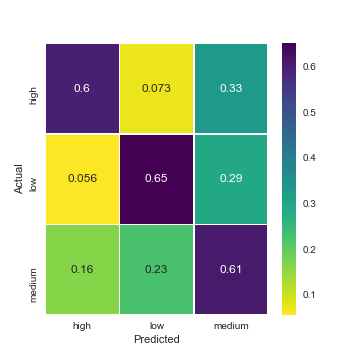

In [53]:
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)
dt_pred = dt_model.predict(X_test)
HTML(evaluate_classification(y_test, dt_pred, average="micro", fs=5))

In [51]:
tree_params = {'class_weight': ["balanced"],
            'criterion': ['gini','entropy'],
            'min_samples_leaf': np.arange(2, 7, 1),
            'max_depth': np.arange(50, 700, 50),
            'max_features': ["sqrt", "log2"]
    }
clf_tree = GridSearchCV(DecisionTreeClassifier(), tree_params, cv=3, verbose=1, n_jobs=-1)
clf_tree.fit(X_train, y_train)
print('Best parameters:', clf_tree.best_params_)
dt_tune_pred = clf_tree.predict(X_test)

Fitting 3 folds for each of 260 candidates, totalling 780 fits


[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    0.8s


Best parameters: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 500, 'max_features': 'sqrt', 'min_samples_leaf': 2}


[Parallel(n_jobs=-1)]: Done 780 out of 780 | elapsed:    2.7s finished



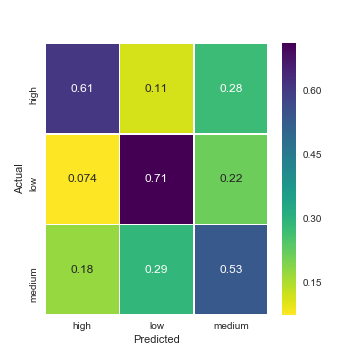

In [52]:
HTML(evaluate_classification(y_test, dt_tune_pred, average="micro", fs=5))

# 6. Regression

## OLS

In [54]:
X = df.drop(['class', 'color', 'quality'], axis=1).as_matrix()
y = df['quality'].values
X_ols = sm.add_constant(X)
ols_model = sm.OLS(y, X_ols).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.292
Model:                            OLS   Adj. R-squared:                  0.291
Method:                 Least Squares   F-statistic:                     243.3
Date:                Sun, 15 Apr 2018   Prob (F-statistic):               0.00
Time:                        07:37:48   Log-Likelihood:                -7215.5
No. Observations:                6497   AIC:                         1.445e+04
Df Residuals:                    6485   BIC:                         1.454e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         55.7627     11.894      4.688      0.0

In [55]:
X_train, X_test, y_train, y_test = prepare_data(df.drop(['class', 'color', 'quality'], axis=1).as_matrix(), df['quality'].values)

## Linear regression

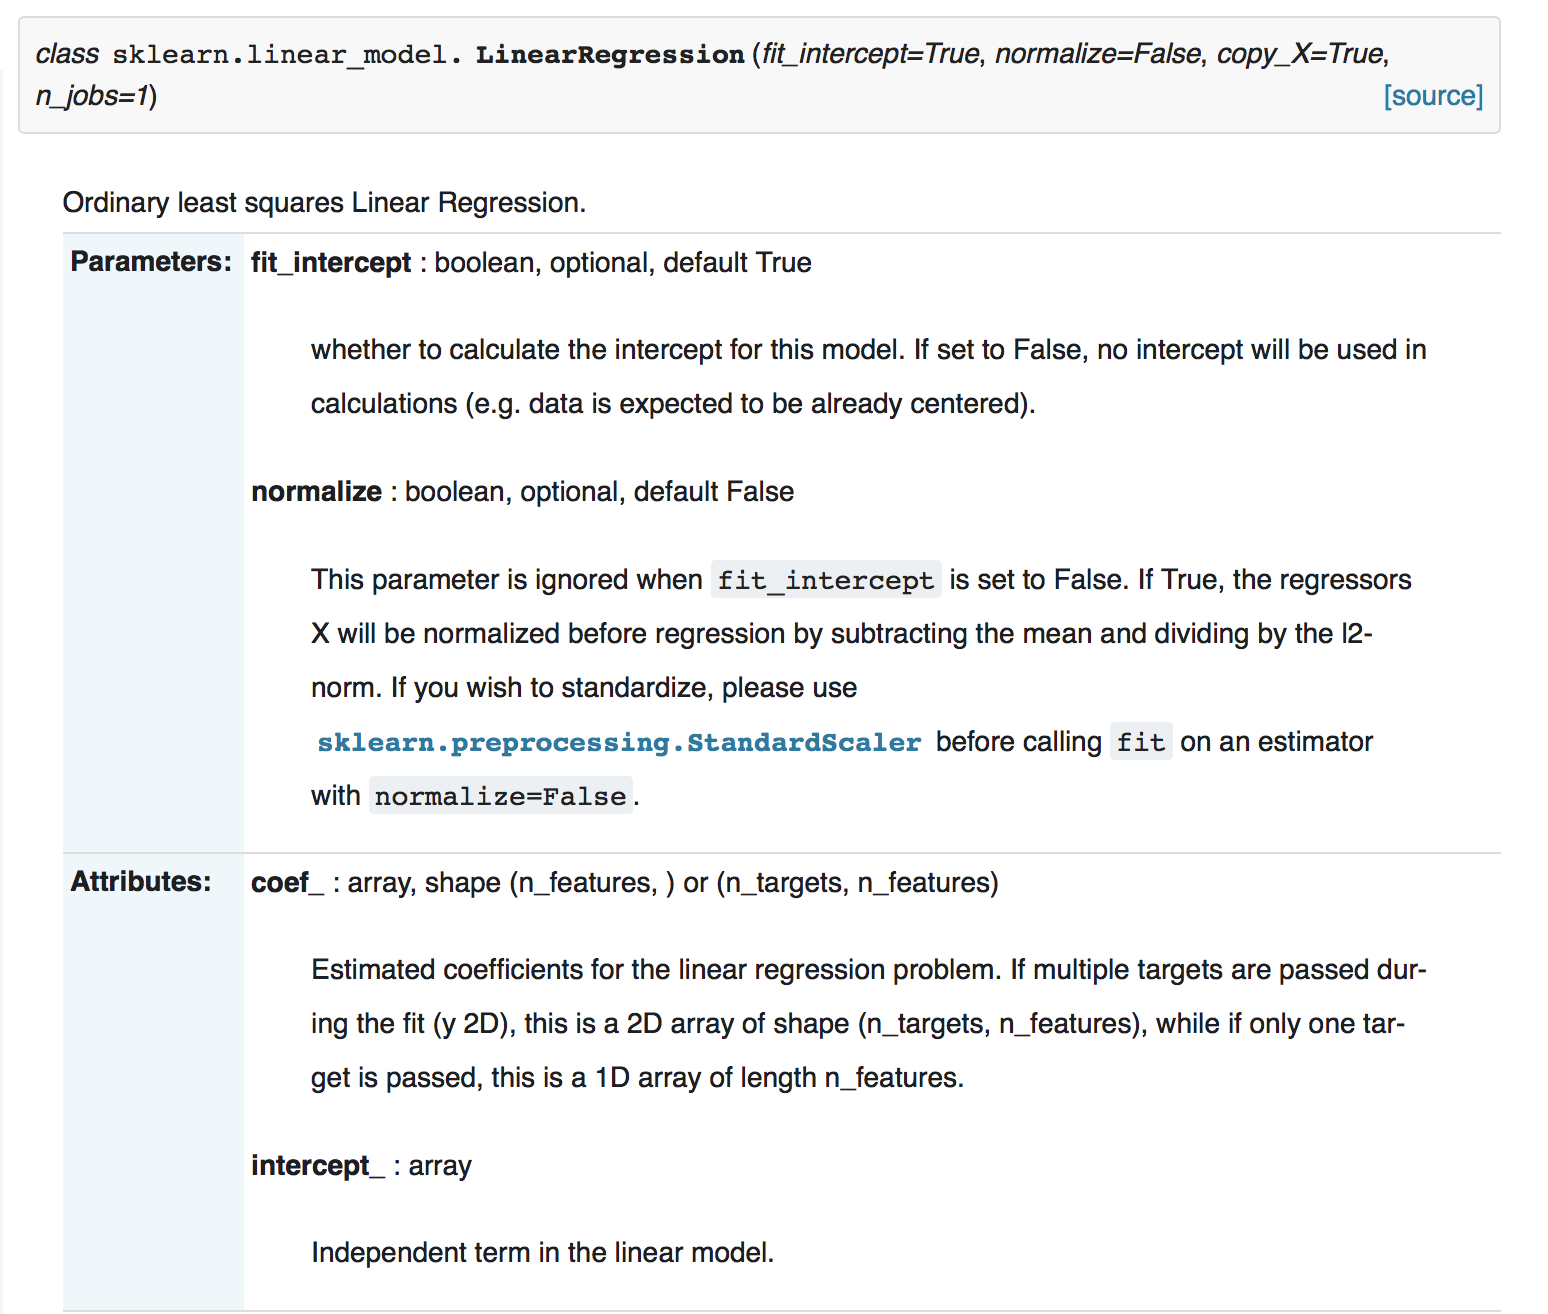

In [62]:
Image(filename='img/lr.png', width='100%')

/usr/local/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


RMSE: 1.4763514259055812
R^2 score: 0.45509661680663926


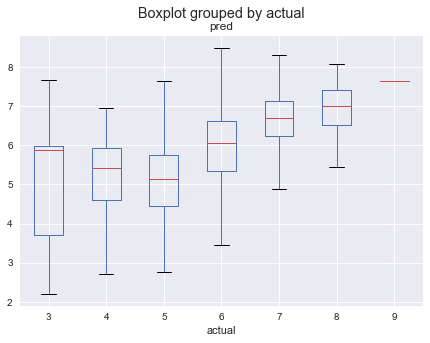

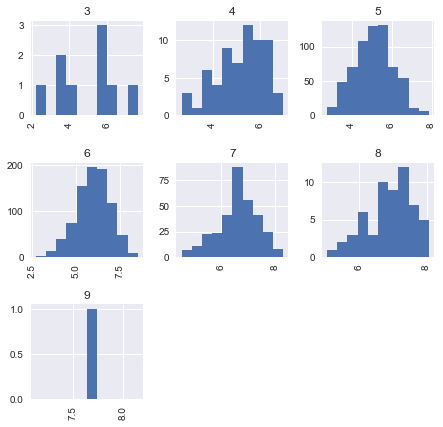

In [57]:
lnr_model = LinearRegression()
sw=compute_sample_weight('balanced', y=y_train)
lnr_model.fit(X_train, y_train, sw)
lnr_pred = lnr_model.predict(X_test)
sw=compute_sample_weight('balanced', y=y_test)
evaluate_regression(y_test, lnr_pred, sample_weight=sw)

## Polynomial regression

RMSE: 1.3122619972607763
R^2 score: 0.5608062731659965


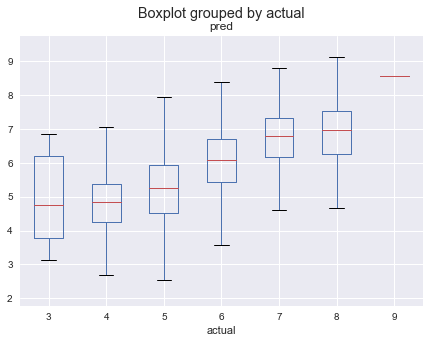

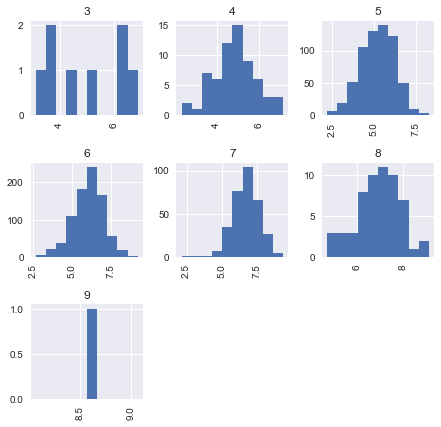

In [58]:
pnr_model = Pipeline([('polynom', PolynomialFeatures(degree=2)), ('linreg', LinearRegression())])
sw=compute_sample_weight('balanced', y=y_train)
pnr_model.fit(X_train, y_train, **{'linreg__sample_weight': sw})
pnr_pred = pnr_model.predict(X_test)
sw=compute_sample_weight('balanced', y=y_test)
evaluate_regression(y_test[pnr_pred>0], pnr_pred[pnr_pred>0], sample_weight=sw[pnr_pred>0])

## Decision Tree

RMSE: 1.5522135543818658
R^2 score: 0.3976582703983036


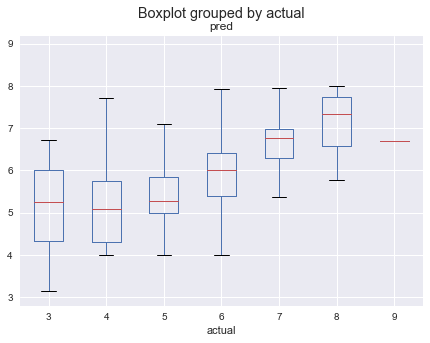

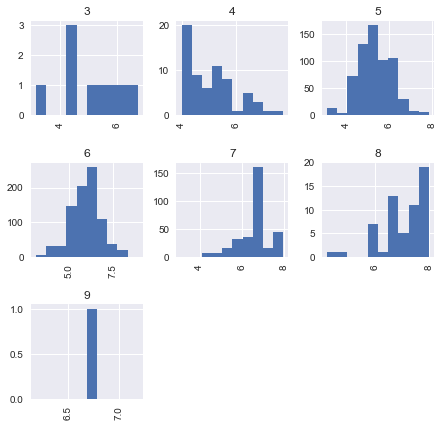

In [59]:
dtr_model = DecisionTreeRegressor(min_samples_leaf=6,random_state=1)
sw=compute_sample_weight('balanced', y=y_train)
dtr_model.fit(X_train, y_train, sample_weight=sw)
dtr_pred = dtr_model.predict(X_test)
sw=compute_sample_weight('balanced', y=y_test)
evaluate_regression(y_test, dtr_pred, sample_weight=sw)

## K-NN

RMSE: 1.6934978888401444
R^2 score: 0.28301622512349345


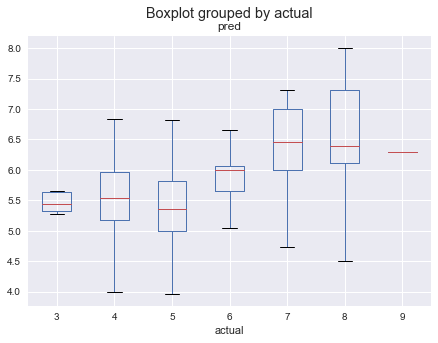

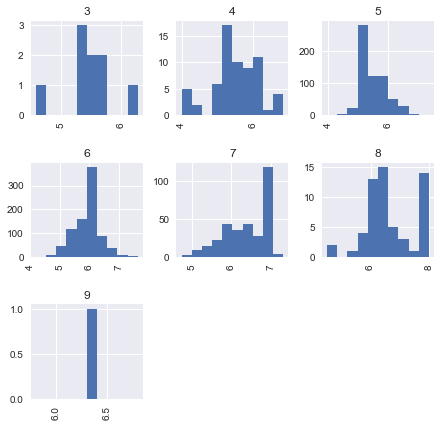

In [60]:
knnr_model = KNeighborsRegressor(n_neighbors=5, weights='distance', algorithm='brute', metric='cosine')
knnr_model.fit(X_train, y_train)
knnr_pred = knnr_model.predict(X_test)
sw=compute_sample_weight('balanced', y=y_test)
evaluate_regression(y_test, knnr_pred,sample_weight=sw)

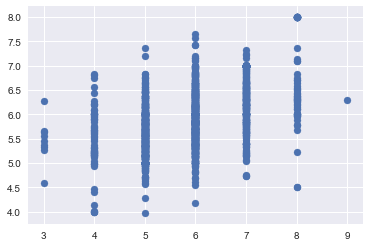

In [61]:
plt.scatter(y_test, knnr_pred)

# 7. Clustering

## Prepare data

In [11]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

X = df.drop(['class', 'color', 'quality'], axis=1).as_matrix()
X = StandardScaler().fit_transform(X)

y = df['class'].values
y_labels = le.fit_transform(y)

In [12]:
df['class'].value_counts()

medium    2836
low       2384
high      1277
Name: class, dtype: int64

In [13]:
np.unique(y, return_counts=True), np.unique(y_labels, return_counts=True)

((array(['high', 'low', 'medium'], dtype=object), array([1277, 2384, 2836])),
 (array([0, 1, 2]), array([1277, 2384, 2836])))

## tSNE vizualization

In [137]:
from sklearn.manifold import TSNE
import time

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=1000, learning_rate=100)
tsne_results = tsne.fit_transform(X)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 6497 samples in 0.004s...
[t-SNE] Computed neighbors for 6497 samples in 1.065s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6497
[t-SNE] Computed conditional probabilities for sample 2000 / 6497
[t-SNE] Computed conditional probabilities for sample 3000 / 6497
[t-SNE] Computed conditional probabilities for sample 4000 / 6497
[t-SNE] Computed conditional probabilities for sample 5000 / 6497
[t-SNE] Computed conditional probabilities for sample 6000 / 6497
[t-SNE] Computed conditional probabilities for sample 6497 / 6497
[t-SNE] Mean sigma: 0.733566
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.714806
[t-SNE] Error after 1000 iterations: 1.423554
t-SNE done! Time elapsed: 207.3122959136963 seconds


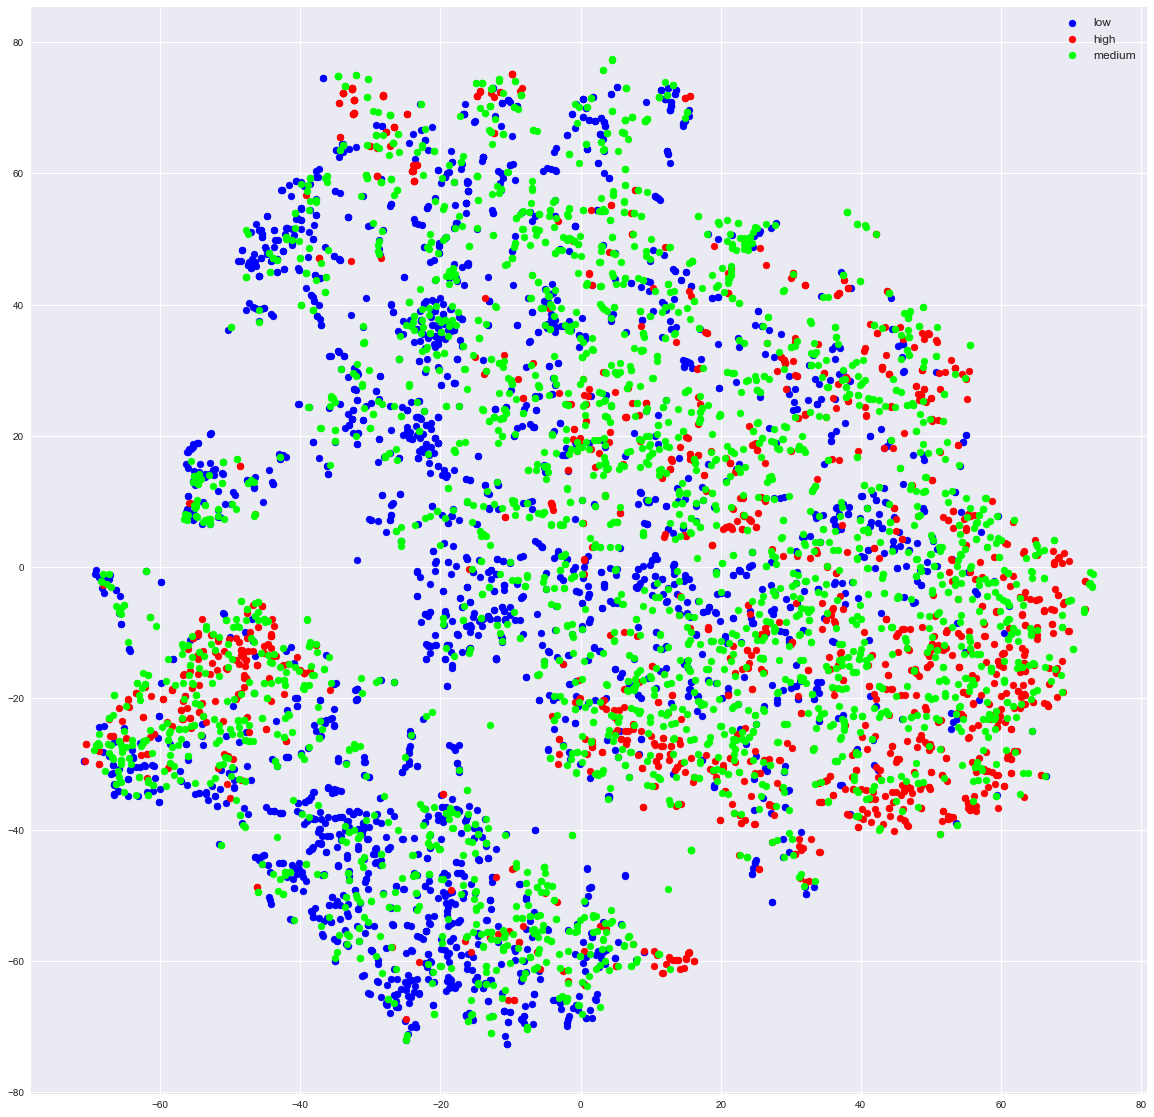

In [138]:
plt.figure(figsize=(20, 20))

unique_labels = list(set(y_labels))
unique = list(set(y))
colors = [plt.cm.brg(float(i)/max(unique_labels)) for i in unique_labels]
for i, u in enumerate(unique):
    #xi = [x[j] for j  in range(len(x)) if classes[j] == u]
    #yi = [y[j] for j  in range(len(x)) if classes[j] == u]
    plt.scatter(tsne_results[y == u, 0], 
                tsne_results[y == u, 1], 
                c=colors[i], 
                label=str(u))
plt.legend(fontsize='large')
plt.show()

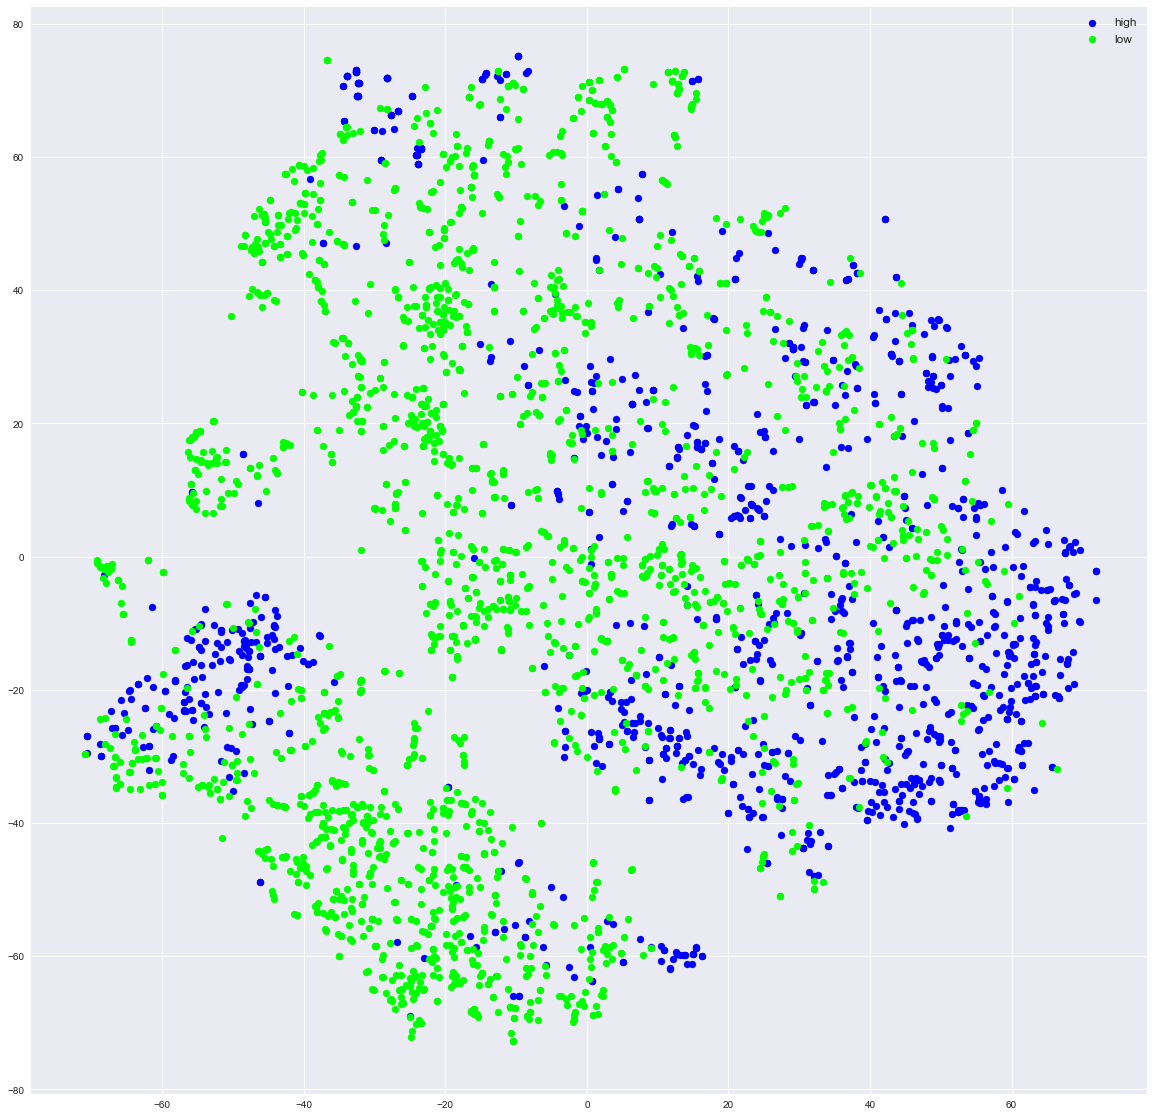

In [139]:
plt.figure(figsize=(20, 20))

unique_labels = [0, 1]
unique = ['high', 'low']
colors = [plt.cm.brg(float(i)/max(unique_labels)) for i in unique_labels]
for i, u in enumerate(unique):
    #xi = [x[j] for j  in range(len(x)) if classes[j] == u]
    #yi = [y[j] for j  in range(len(x)) if classes[j] == u]
    plt.scatter(tsne_results[y == u, 0], 
                tsne_results[y == u, 1], 
                c=colors[i], 
                label=str(u))
plt.legend(fontsize='large')
plt.show()

## K-Means

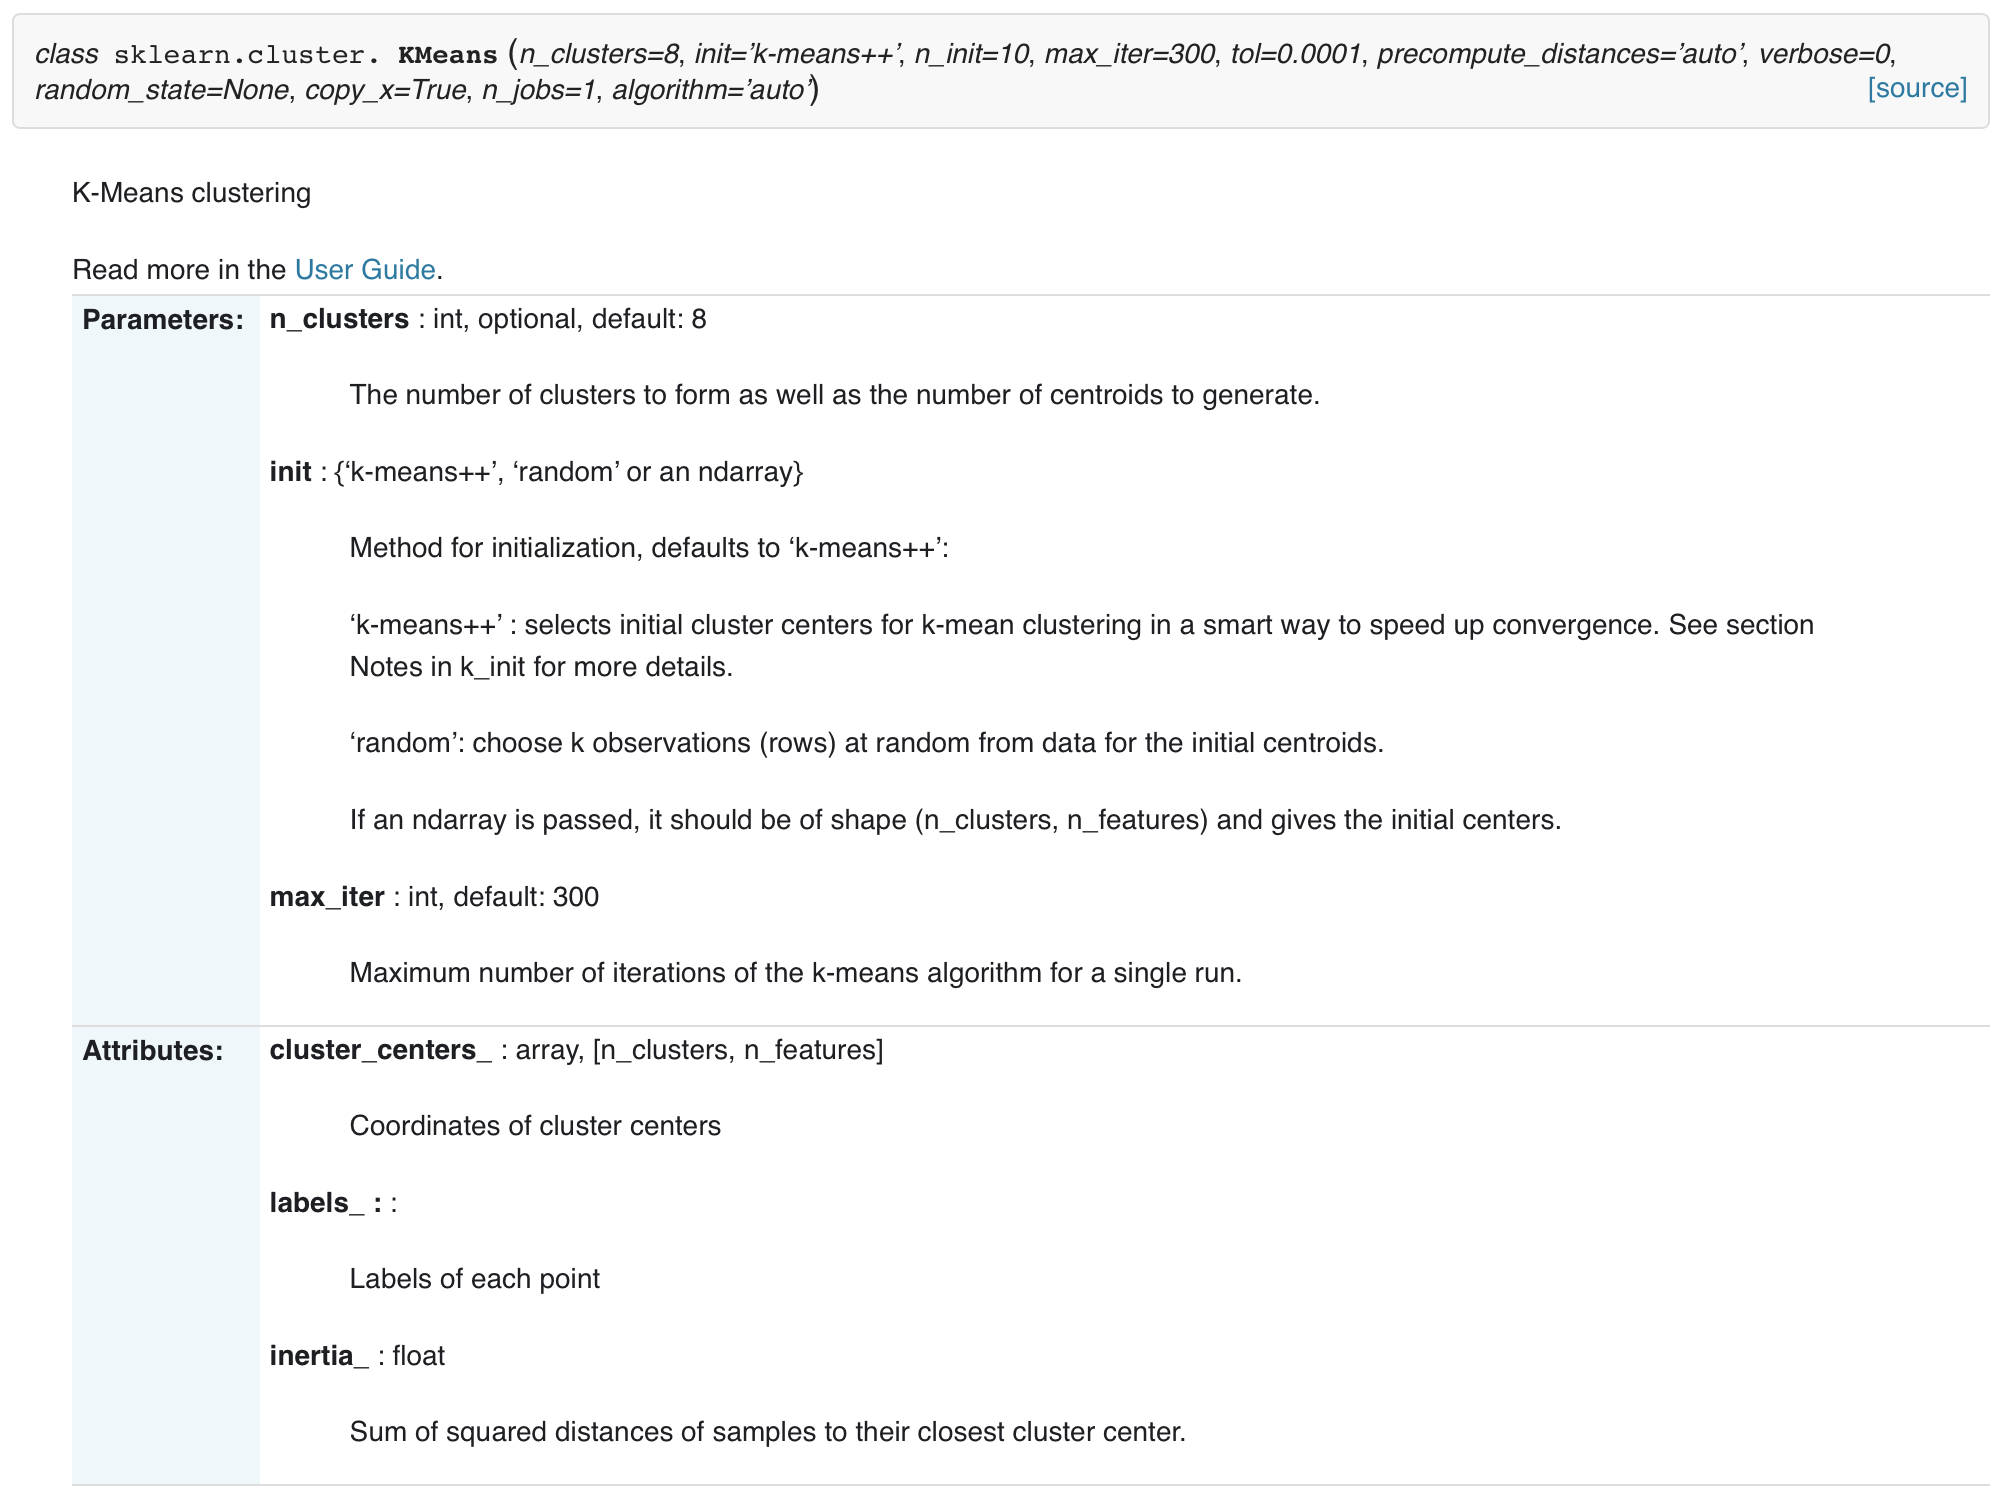

In [41]:
Image(filename='img/kmeans.png', width='100%')

100%|██████████| 18/18 [00:36<00:00,  2.08s/it]


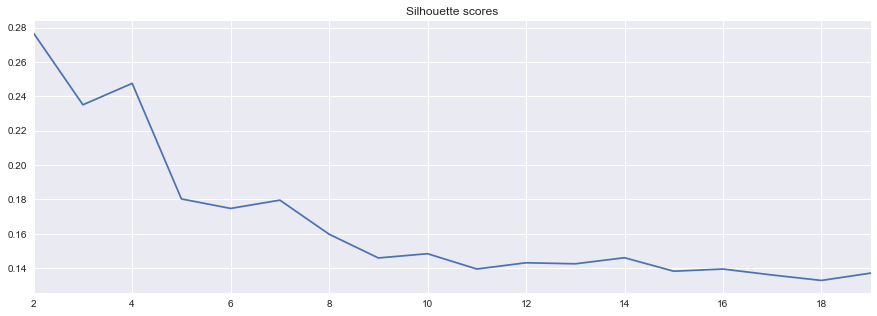

In [145]:
scores = []
for nclust in tqdm(np.arange(2,20)):
    kmeans = KMeans(n_clusters=nclust, random_state=42)
    kmeans.fit(X)
    scores.append(metrics.silhouette_score(X, kmeans.labels_))

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 20), scores)
plt.grid(True)
plt.xlim(2,19)
plt.title('Silhouette scores')

## Hierarchical clustering

In [14]:
def evaluate_hclust_test(y, link):
    amis, chs, ss, vs = [], [], [], []
    for k in range(2,51):
        clusters = fcluster(link, k, 'maxclust')
        amis.append(metrics.adjusted_mutual_info_score(y, clusters))
        chs.append(metrics.calinski_harabaz_score(X, clusters))
        ss.append(metrics.silhouette_score(X, clusters))
        vs.append(metrics.v_measure_score(y, clusters))
    
    fig, rows = plt.subplots(2, 2, figsize=(15,10))
    rows[0][0].plot(range(2,51), amis)
    rows[0][0].set_xlim(2,50)
    rows[0][0].set_title("adjusted mutual info score")
    rows[0][1].plot(range(2,51), chs)
    rows[0][1].set_xlim(2,50)
    rows[0][1].set_title("calinski harabas score")
    rows[1][0].plot(range(2,51), vs)
    rows[1][0].set_xlim(2,50)
    rows[1][0].set_title("v-score")
    rows[1][1].plot(range(2,51), ss)
    rows[1][1].set_xlim(2,50)
    rows[1][1].set_title("silhouette score")

## Single

In [15]:
single = linkage(pdist(X), 'single')

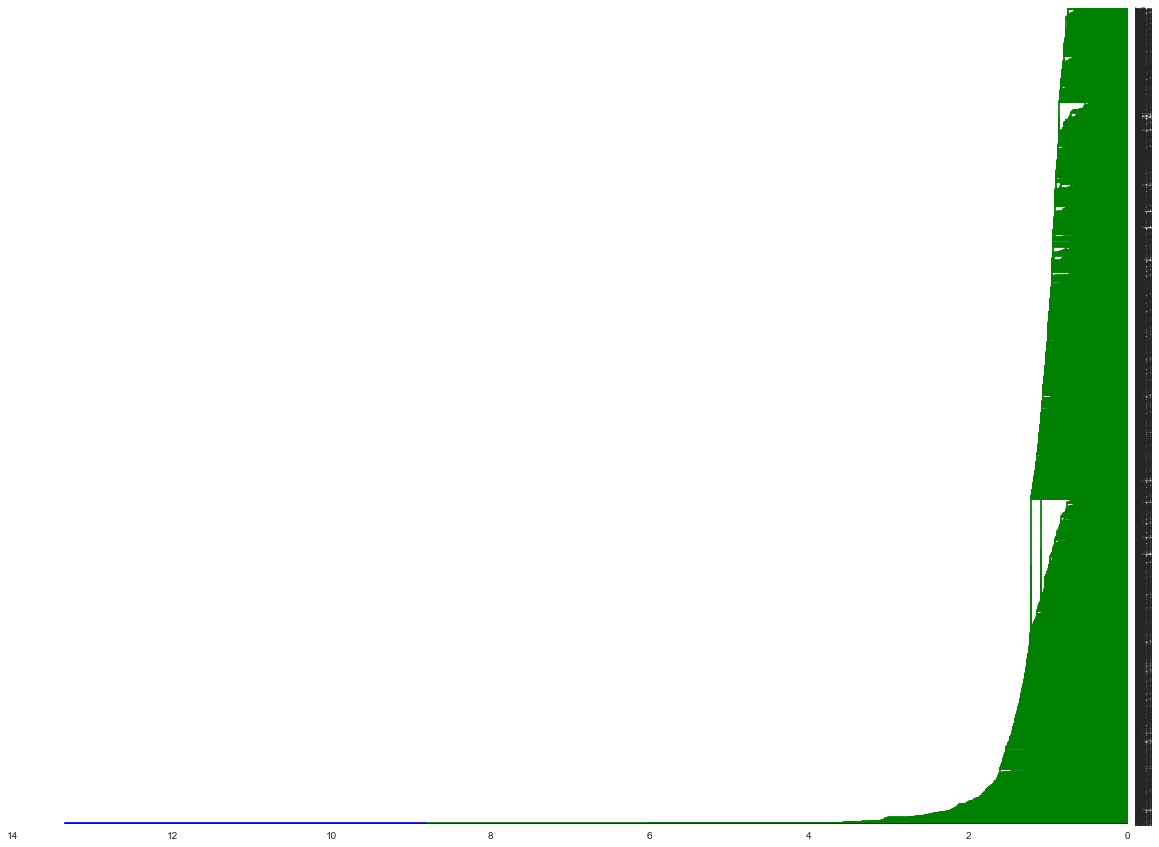

In [16]:
import sys
sys.setrecursionlimit(10000)

fig, ax = plt.subplots(figsize=(20, 15))
_ = dendrogram(single, orientation='left', labels=y, ax=ax)

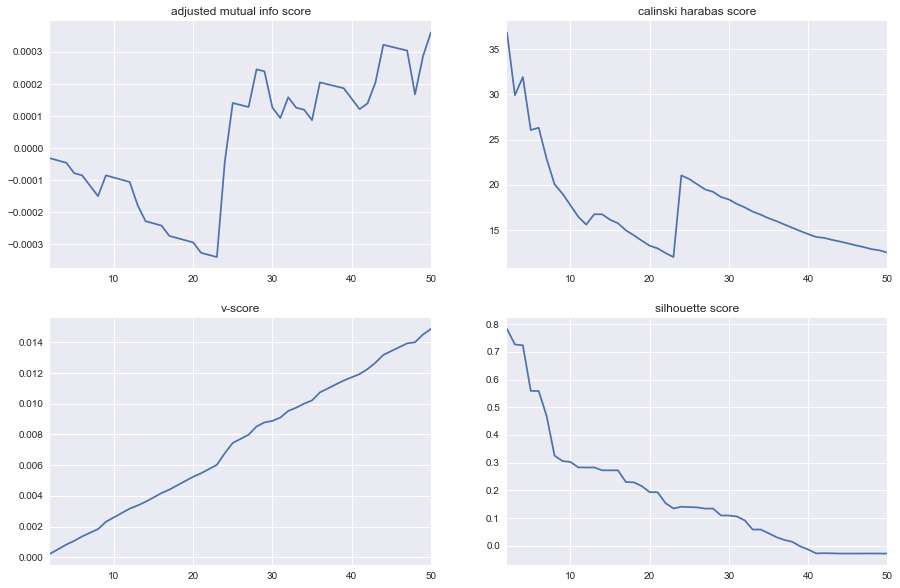

In [17]:
evaluate_hclust_test(y, single)

## Average

In [18]:
average = linkage(pdist(X), 'average')

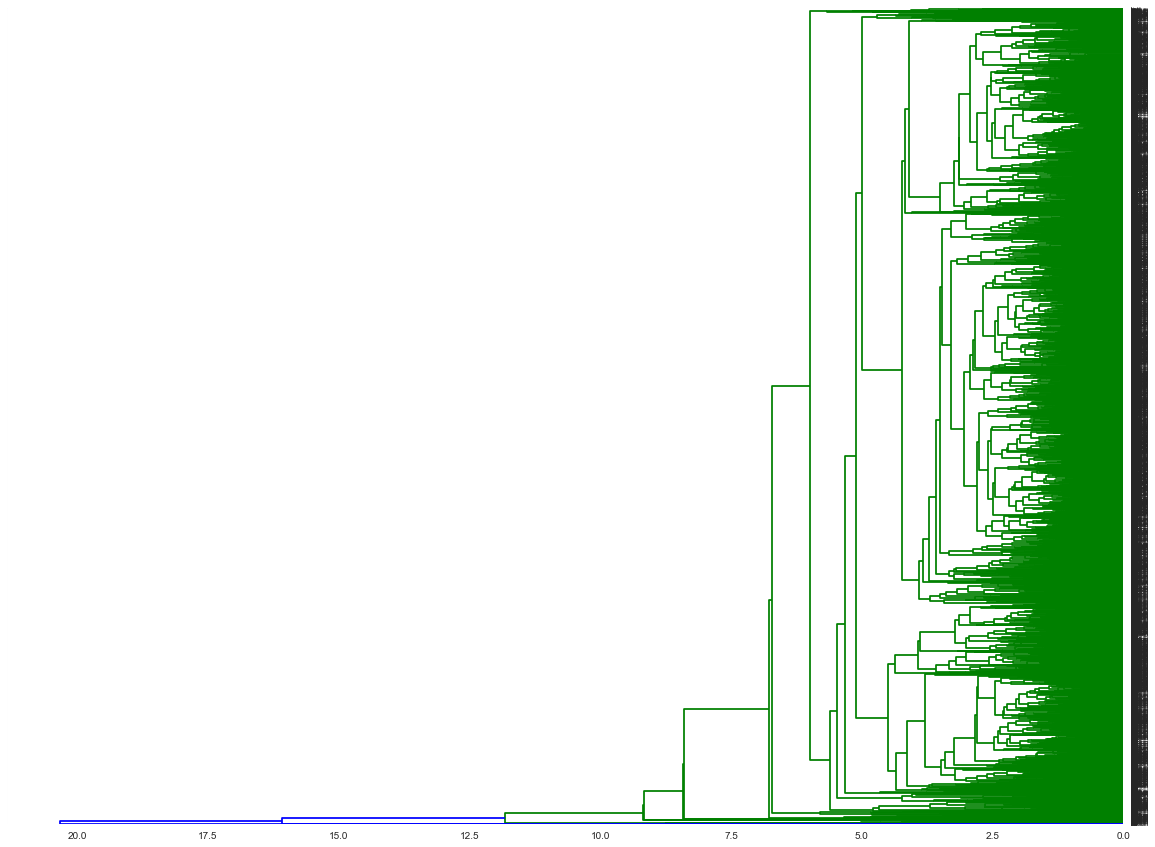

In [19]:
fig, ax = plt.subplots(figsize=(20, 15))
_ = dendrogram(average, orientation='left', labels=y, ax=ax)

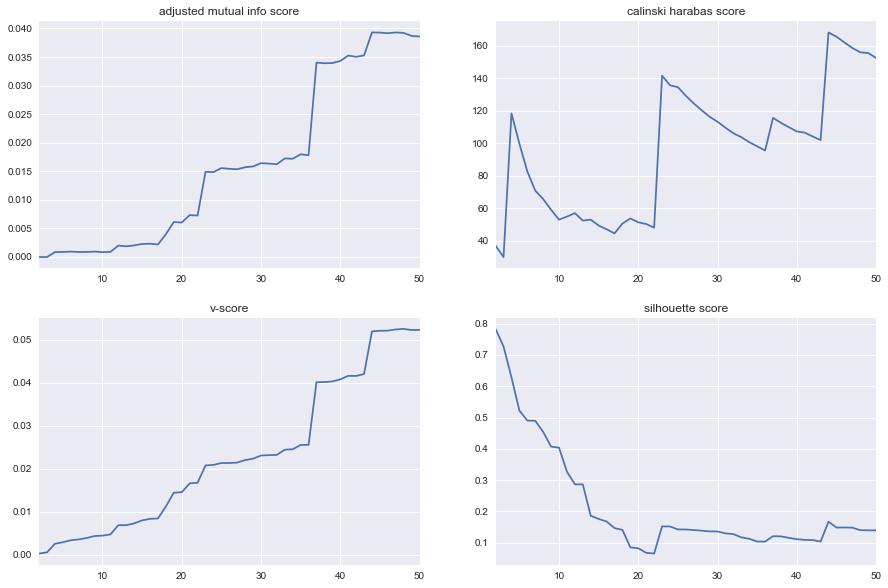

In [20]:
evaluate_hclust(y, average)

## Complete

In [21]:
complete = linkage(pdist(X), 'complete')

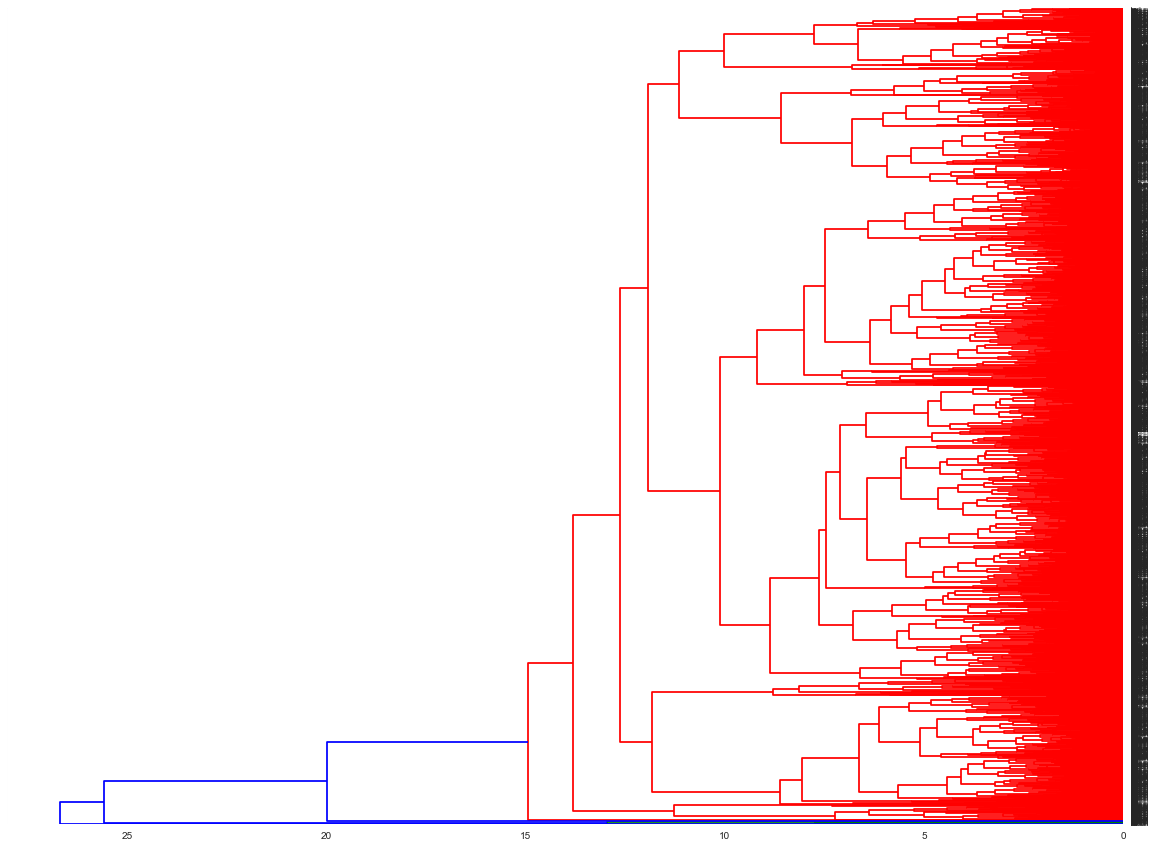

In [22]:
fig, ax = plt.subplots(figsize=(20, 15))
_ = dendrogram(complete, orientation='left', labels=y, ax=ax)

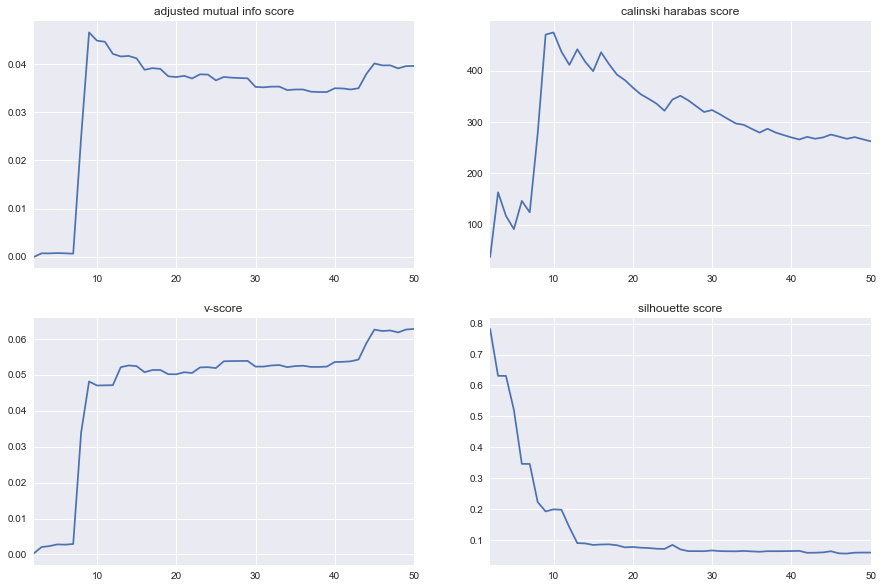

In [23]:
evaluate_hclust(y, complete)

## Matching clusters and classes


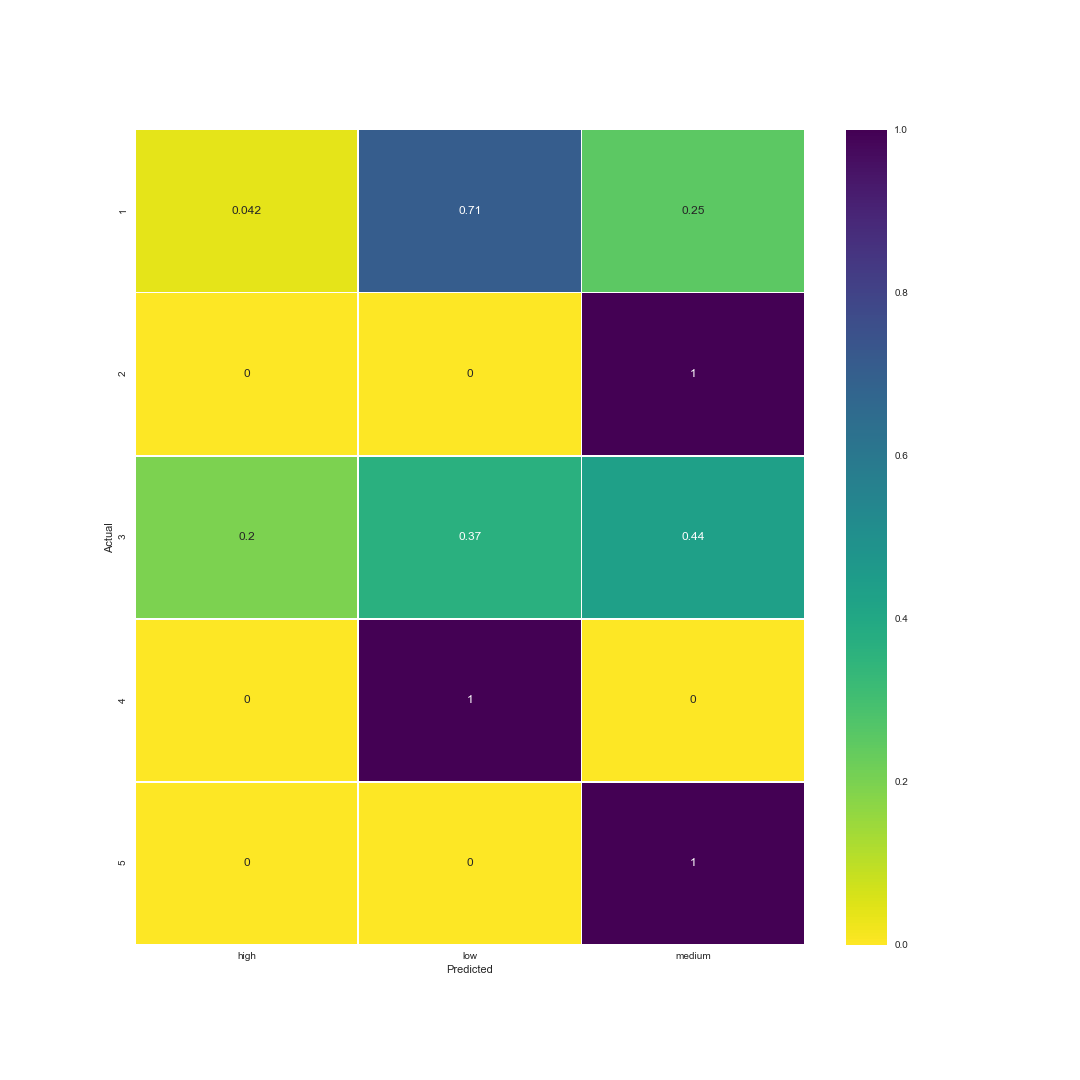

In [29]:
clusters = fcluster(complete, 5, 'maxclust')

metrics.fowlkes_mallows_score(y,clusters)
HTML(confusion_matrix_picture(clusters,y,fs=15))


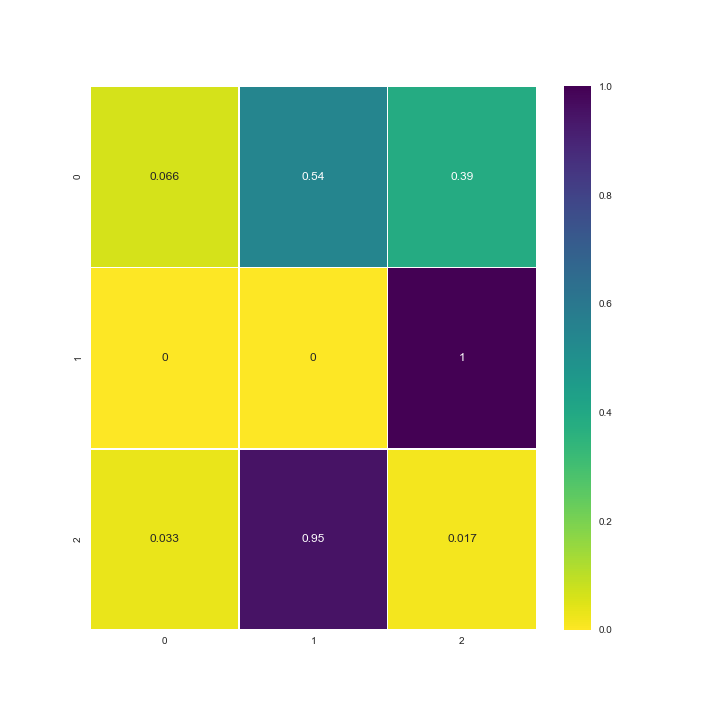

In [31]:
clusters = fcluster(average, 18, 'maxclust')
mm=np.array(confusion_matrix_simple(clusters,y))
from scipy.spatial import distance_matrix, distance
dst=np.zeros([len(mm), len(mm)])
for k in range(len(mm)):
    for j in range(len(mm)):
        dst[k,j]=distance.cosine(mm[k],mm[j])

clust = KMeans(n_clusters = 3, max_iter=5000, algorithm='full').fit(mm)
clusters = clust.predict(mm)

HTML(clust_matrix_picture(clust.cluster_centers_, fs=10))

## Interpretation of clusters

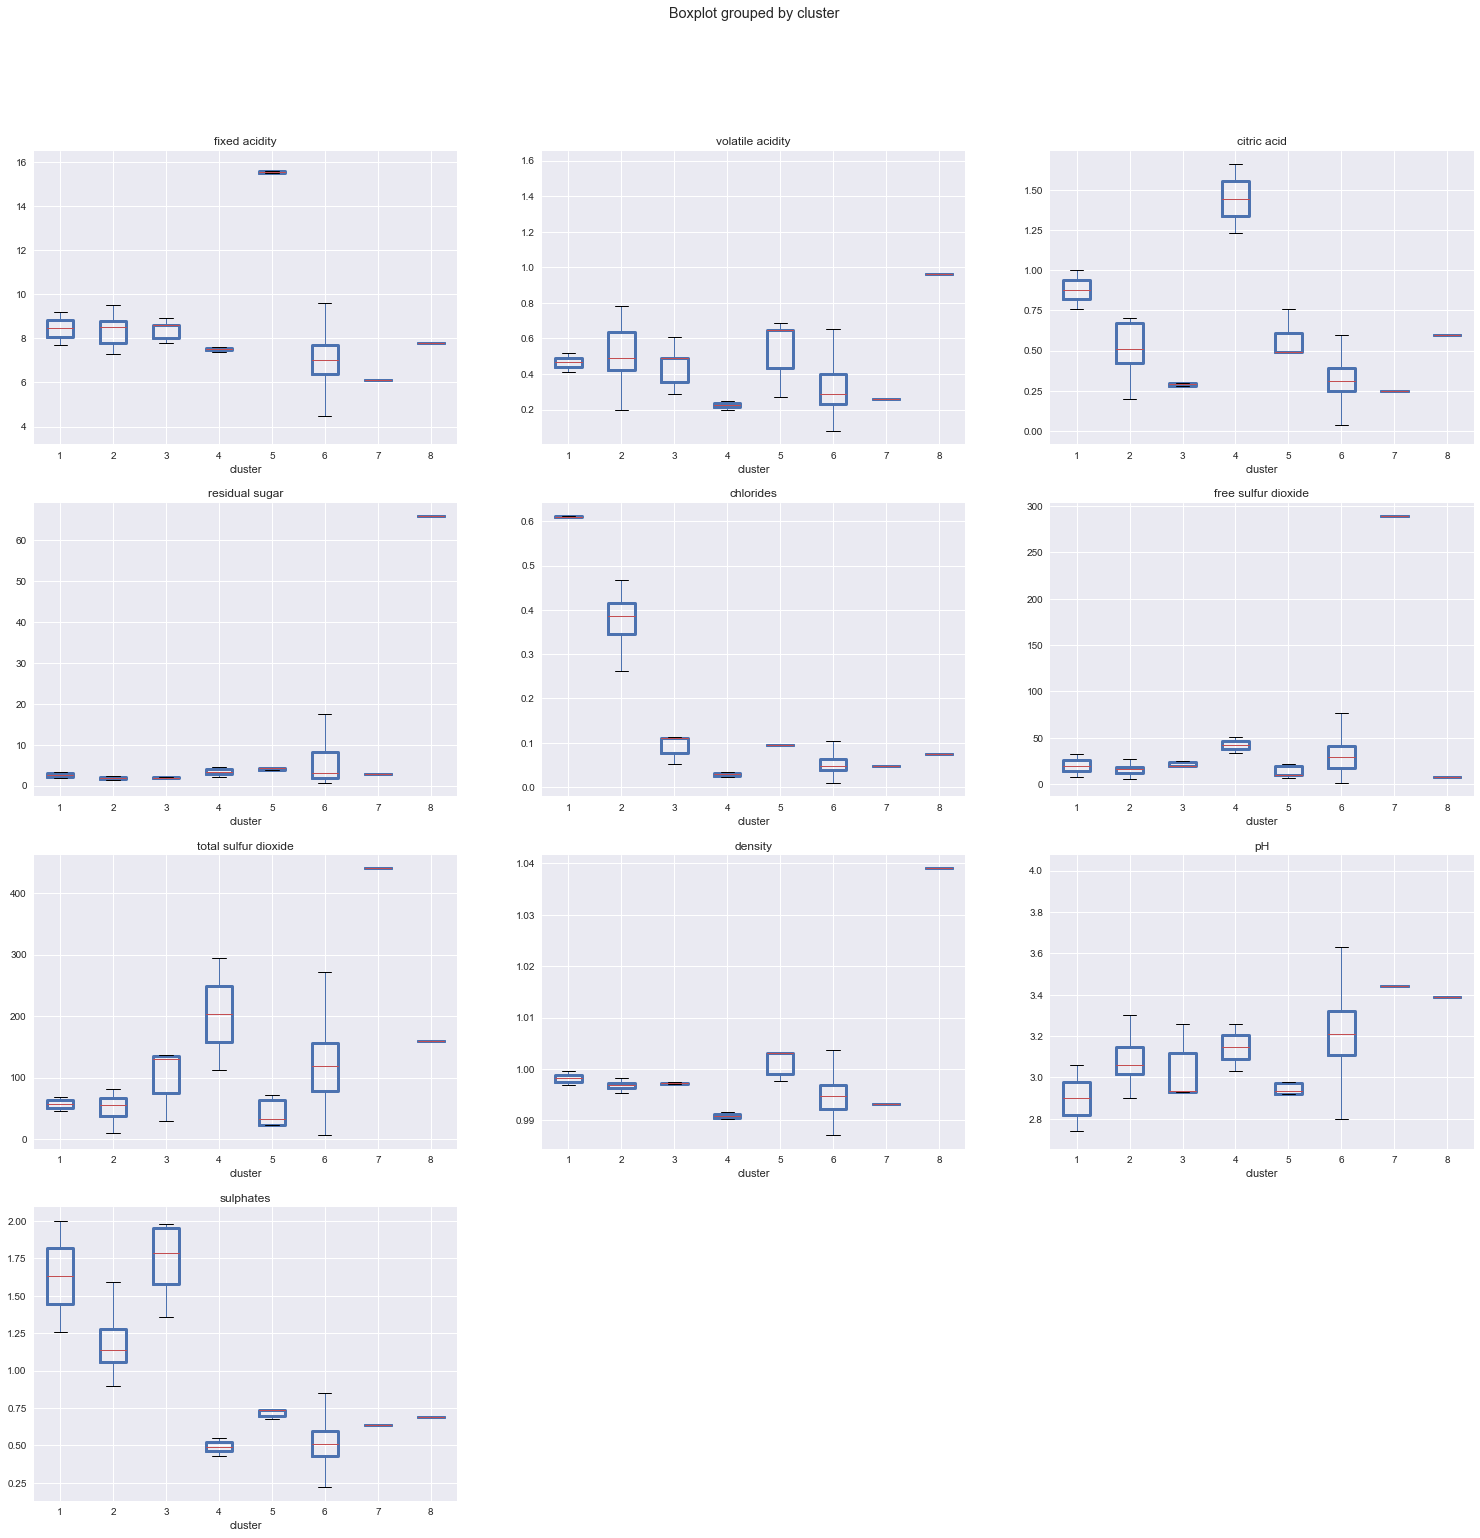

In [34]:
clusters = fcluster(average, 8, 'maxclust')
plt.figure(figsize=[25,25])
k=0
for nm in df.columns[0:10]:
    k=k+1
    ax=plt.subplot(4,3,k)
    ddf=pd.DataFrame({nm:df[nm], 'cluster':clusters})
    ddf.boxplot(nm, 'cluster', ax=ax, boxprops=dict(linestyle='-', linewidth=3, color='k'))